In [1]:
!pip install git+https://github.com/jkirkby3/pymle.git

  Cloning https://github.com/jkirkby3/pymle.git to /tmp/pip-req-build-t1lhpby2
  Running command git clone --filter=blob:none --quiet https://github.com/jkirkby3/pymle.git /tmp/pip-req-build-t1lhpby2
  Resolved https://github.com/jkirkby3/pymle.git to commit 412f74f5201782686f13ed2c60acd07b740c42e8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pymle-diffusion: filename=pymle_diffusion-0.0.4-py3-none-any.whl size=40920 sha256=eff078b043b26993cdba2331308bced7c66c4ea2674cbee24a634c223c8a5493
  Stored in directory: /tmp/pip-ephem-wheel-cache-s8d3y_2b/wheels/c6/98/81/1f0aae719591ab3a7cedd5fe86384f4b7bd9d79193905bf807
Successfully built pymle-diffusion


In [ ]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np, scipy.stats as st

from scipy.stats import norm
from tqdm import tqdm
from pymle.models import CIR, CKLS, OrnsteinUhlenbeck
from pymle.sim.Simulator1D import Simulator1D
from pymle.core.TransitionDensity import ExactDensity, KesslerDensity, OzakiDensity, EulerDensity, ShojiOzakiDensity
from pymle.fit.AnalyticalMLE import AnalyticalMLE

In [ ]:
# Define auxiliary function to find minimal value
def argmin(iterable):
    return min(enumerate(iterable), key=lambda x: x[1])[0]

Task 1. Constant Maturity Interest Rates. Fit models (CEV, CIR, OU, CKLS) to a sample of historical interest rates over the period Jan 1, 1962 to till now. Plot the historical daily time series and three time-discretization
benchmarks:
*   Kessler method,
*   Shoji-Ozaki method,
*   Euler method

using MLE approach.

The estimated parameters display in a table for each method. Calculate the AIC and select the best model. Compare your results with paper by Kirkby et. al (https://arxiv.org/abs/2108.12649) where the period from Jan 1, 1962 to April 8, 2021 (14,801 daily observations).

Dataset: Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (DGS10),
https://fred.stlouisfed.org/series/DGS10  

In [ ]:
import pandas as pd
import requests

# URL for the DGS10 series
url = 'https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1140&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=DGS10&scale=left&cosd=2019-11-07&coed=2024-11-07&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=3&ost=-99999&oet=99999&mma=0&fml=a&fq=Daily&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2024-11-09&revision_date=2024-11-09&nd=1962-01-02'

# Send the GET request
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Save the content to a local file
    with open('DGS10.csv', 'wb') as f:
        f.write(response.content)
    print("Data downloaded successfully.")
else:
    print(f"Failed to download data. Status code: {response.status_code}")

# Load the data into a Pandas DataFrame
data = pd.read_csv('DGS10.csv', sep='\t')

# Display the first few rows of the dataset
print(data.head())

Data downloaded successfully.
        DATE,DGS10
0  2019-11-07,1.92
1  2019-11-08,1.94
2     2019-11-11,.
3  2019-11-12,1.92
4  2019-11-13,1.88


In [ ]:
# Read data and preprocessing it
df_IR = pd.read_csv('DGS10.csv')
df_IR = df_IR[df_IR['DGS10'] != '.']

# Make valid numerical sample
sample = df_IR['DGS10'].values
sample = [float(sample[i]) for i in range(len(sample))]
sample = np.array(sample)

Task. Download the DGS10 dataset directlly from https://fred.stlouisfed.org/series/DGS10 .

Hint.

Use  
`from pymle.data.loader import load_10yr_CMrate`

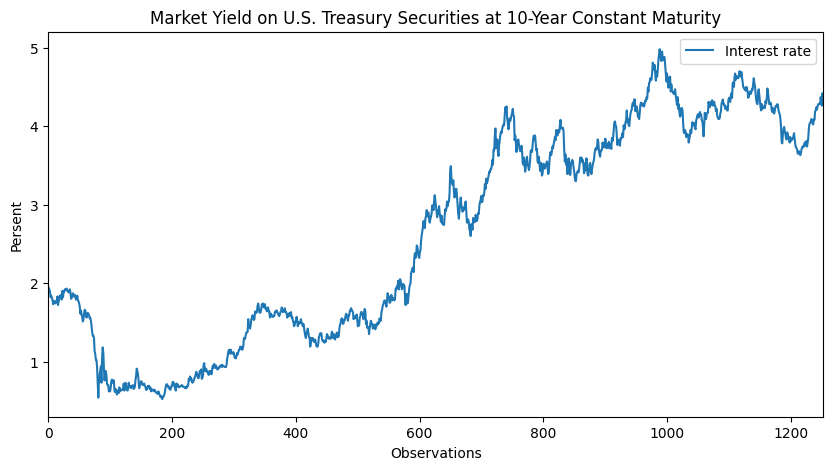

In [ ]:
# Plot
figure, ax = plt.subplots(figsize=(10,5))
ax.plot(np.linspace(0, len(sample), len(sample)),sample, label='Interest rate')
plt.title('Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity')
plt.xlim(0, len(sample))
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.show()

Task. Change the X marks to dates.

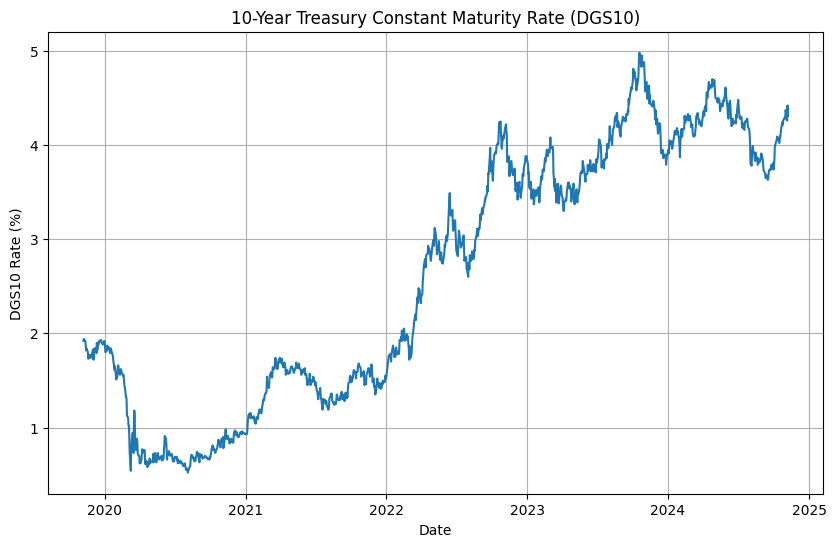

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(df_IR["DATE"]), pd.to_numeric(df_IR["DGS10"]))
plt.title("10-Year Treasury Constant Maturity Rate (DGS10)")
plt.xlabel("Date")
plt.ylabel("DGS10 Rate (%)")
plt.grid()
plt.show()

In [ ]:
# Import models for fitting:
from pymle.models import BrownianMotion, CEV, CIR,\
                         CKLS, GeometricBM, IGBM, \
                         OrnsteinUhlenbeck

In [ ]:
# a) fit using Kessler method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

# Set parameters for estimators:
dt = 1. / 252

# Estimate max likelyhood, using KesslerDensity
kessler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
kessler_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.71867852545
`xtol` termination condition is satisfied.
Number of iterations: 33, function evaluations: 84, CG iterations: 52, optimality: 3.11e-04, constraint violation: 0.00e+00, execution time: 0.13 s.
Final Params: [0.481522   0.99614988]
Final Likelihood: 1688.3914757364125
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.47065226873
`xtol` termination condition is satisfied.
Number of iterations: 97, function evaluations: 490, CG iterations: 331, optimality: 6.59e-01, constraint violation: 0.00e+00, execution time: 0.58 s.
Final Params: [0.10600325 0.29233766 0.81798006 0.22299976]
Final Likelihood: 1713.4223556812387
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2708.3033326472587
`xtol` termination condition is satisfied.
Number of iterations: 48, function evaluations: 240, CG iterations: 88, optimality: 4.41e+00, constraint violation: 0.00e+00, execution time: 0.21 s.
Final Params: [0.03169702 0.21

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 116, function evaluations: 590, CG iterations: 392, optimality: 2.68e+00, constraint violation: 0.00e+00, execution time:  1.5 s.
Final Params: [0.39731388 0.05499657 0.81693006 0.22932784]
Final Likelihood: 1714.7216302436427
Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.71867852545
`xtol` termination condition is satisfied.
Number of iterations: 33, function evaluations: 84, CG iterations: 52, optimality: 3.11e-04, constraint violation: 0.00e+00, execution time: 0.25 s.
Final Params: [0.481522   0.99614988]
Final Likelihood: 1688.3914757364125
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.47065226873
`xtol` termination condition is satisfied.
Number of iterations: 97, function evaluations: 490, CG iterations: 331, optimality: 6.59e-01, constraint violation: 0.00e+00, execution time: 0.89 s.
Final Params: [0.10600325 0.29233766 0.81798006 0.22299976]
Final Likelihood: 1713.4223556812387
Initi

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 48, function evaluations: 240, CG iterations: 88, optimality: 4.41e+00, constraint violation: 0.00e+00, execution time:  0.2 s.
Final Params: [0.03169702 0.21024592 0.68093409]
Final Likelihood: 1669.323628781751
Initial Params: [0.01, 0.2]
Initial Likelihood: -943.8115685429168
`xtol` termination condition is satisfied.
Number of iterations: 35, function evaluations: 108, CG iterations: 50, optimality: 1.19e+01, constraint violation: 0.00e+00, execution time:  0.1 s.
Final Params: [0.21884373 0.592392  ]
Final Likelihood: 1355.2067851546897
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -944.9213330728604
`xtol` termination condition is satisfied.
Number of iterations: 172, function evaluations: 704, CG iterations: 366, optimality: 2.80e-04, constraint violation: 0.00e+00, execution time: 0.92 s.
Final Params: [0.74225905 2.53805001 0.59042745]
Final Likelihood: 1359.546658203682
Initial Params: [0.01, 0.01, 0.2]


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


In [ ]:
best_ind = argmin(kessler_est)
print("AIC values for Kessler estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     kessler_est[0], model_name[0], kessler_params[0],\
     kessler_est[1], model_name[1], kessler_params[1],\
     kessler_est[2], model_name[2], kessler_params[2],\
     kessler_est[3], model_name[3], kessler_params[3],\
     kessler_est[4], model_name[4], kessler_params[4],\
     kessler_est[5], model_name[5], kessler_params[5],\
     kessler_est[6], model_name[6], kessler_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], kessler_params[best_ind]))

AIC values for Kessler estimation:
       -3372.783 - BrownianMotion model with params [0.481522   0.99614988],
       -3418.845 - CEV model with params [0.10600325 0.29233766 0.81798006 0.22299976],
       -3332.647 - CIR model with params [0.03169702 0.21024592 0.68093409],
       -2706.414 - GeometricBM model with params [0.21884373 0.592392  ],
       -2713.093 - IGBM model with params [0.74225905 2.53805001 0.59042745],
       -3370.952 - OrnsteinUhlenbeck model with params [0.11147746 6.97863559 0.9960855 ],
       -3421.443 - CKLS model with params [0.39731388 0.05499657 0.81693006 0.22932784],
       
The best model is CKLS     with param [0.39731388 0.05499657 0.81693006 0.22932784]


In [ ]:
# b) fit using Shoji-Ozaki method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

# Set parameters for estimators:
dt = 1. / 252
K = 1

# Estimate max likelyhood, using Shoji-Ozaki
shoji_ozaki_est      = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
shoji_ozaki_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.718678524912
`gtol` termination condition is satisfied.
Number of iterations: 31, function evaluations: 72, CG iterations: 42, optimality: 4.68e-07, constraint violation: 0.00e+00, execution time: 0.13 s.
Final Params: [0.4814409  0.99614996]
Final Likelihood: 1688.3914757537532
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.58998907219
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 1215, CG iterations: 940, optimality: 1.66e-02, constraint violation: 0.00e+00, execution time:  1.5 s.
Final Params: [0.01723236 0.81771457 0.81878965 0.22476894]
Final Likelihood: 1714.0170844049203
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2710.3378924874087
`xtol` termination condition is satisfied.
Number of iterations: 104, function evaluations: 392, CG iterations: 230, optimality: 2.23e-01, constraint violation: 0.00e+00, execution time: 0.78 s.
Final Params

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 96, function evaluations: 380, CG iterations: 214, optimality: 1.45e-01, constraint violation: 0.00e+00, execution time: 0.67 s.
Final Params: [0.15206511 4.23260371 0.99649128]
Final Likelihood: 1688.339193010072
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79286.4317422433
`xtol` termination condition is satisfied.
Number of iterations: 78, function evaluations: 405, CG iterations: 225, optimality: 5.76e-03, constraint violation: 0.00e+00, execution time: 0.75 s.
Final Params: [0.40863373 0.05356565 0.81768721 0.22557641]
Final Likelihood: 1714.73388954513
Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.718678524912
`gtol` termination condition is satisfied.
Number of iterations: 31, function evaluations: 72, CG iterations: 42, optimality: 4.68e-07, constraint violation: 0.00e+00, execution time: 0.21 s.
Final Params: [0.4814409  0.99614996]
Final Likelihood: 1688.3914757537532
Initial Params: [0.0

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


In [ ]:
best_ind = argmin(shoji_ozaki_est)
print("AIC values for Shoji-Ozaki estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     shoji_ozaki_est[0], model_name[0], shoji_ozaki_params[0],\
     shoji_ozaki_est[1], model_name[1], shoji_ozaki_params[1],\
     shoji_ozaki_est[2], model_name[2], shoji_ozaki_params[2],\
     shoji_ozaki_est[3], model_name[3], shoji_ozaki_params[3],\
     shoji_ozaki_est[4], model_name[4], shoji_ozaki_params[4],\
     shoji_ozaki_est[5], model_name[5], shoji_ozaki_params[5],\
     shoji_ozaki_est[6], model_name[6], shoji_ozaki_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], shoji_ozaki_params[best_ind]))

AIC values for Shoji-Ozaki estimation:
       -3372.783 - BrownianMotion model with params [0.4814409  0.99614996],
       -3420.034 - CEV model with params [0.01723236 0.81771457 0.81878965 0.22476894],
       -3334.729 - CIR model with params [0.31014689 3.34753837 0.68419535],
       -2708.849 - GeometricBM model with params [0.32631368 0.59422328],
       -2711.256 - IGBM model with params [0.42076929 3.17959528 0.59405479],
       -3370.678 - OrnsteinUhlenbeck model with params [0.15206511 4.23260371 0.99649128],
       -3421.468 - CKLS model with params [0.40863373 0.05356565 0.81768721 0.22557641],
       
The best model is CKLS     with param [0.40863373 0.05356565 0.81768721 0.22557641]


In [ ]:
# c) fit using Euler method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

# Set parameters for estimators:
dt = 1. / 252
K = 1

# Estimate max likelyhood, using Shoji-Ozaki
euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
eu_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.718678524914
`gtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 66, CG iterations: 38, optimality: 4.68e-07, constraint violation: 0.00e+00, execution time: 0.17 s.
Final Params: [0.48143899 0.99614996]
Final Likelihood: 1688.3914757537636
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.45728481325


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 92, function evaluations: 455, CG iterations: 251, optimality: 3.21e-06, constraint violation: 0.00e+00, execution time: 0.78 s.
Final Params: [0.09882615 7.45534004 0.8177117  0.22555163]
Final Likelihood: 1714.8509939689093
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2710.1287756483916
`xtol` termination condition is satisfied.
Number of iterations: 89, function evaluations: 336, CG iterations: 173, optimality: 7.83e-06, constraint violation: 0.00e+00, execution time: 0.65 s.
Final Params: [0.12312797 6.52508367 0.68367189]
Final Likelihood: 1670.5511057641147
Initial Params: [0.01, 0.2]
Initial Likelihood: -946.9283375573104
`xtol` termination condition is satisfied.
Number of iterations: 45, function evaluations: 102, CG iterations: 70, optimality: 1.11e-06, constraint violation: 0.00e+00, execution time: 0.26 s.
Final Params: [0.33680804 0.59460504]
Final Likelihood: 1356.425169078746
Initial Params: [0.01

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


In [ ]:
best_ind = argmin(euler_est)
print("AIC values for Euler estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     euler_est[0], model_name[0], eu_params[0],\
     euler_est[1], model_name[1], eu_params[1],\
     euler_est[2], model_name[2], eu_params[2],\
     euler_est[3], model_name[3], eu_params[3],\
     euler_est[4], model_name[4], eu_params[4],\
     euler_est[5], model_name[5], eu_params[5],\
     euler_est[6], model_name[6], eu_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], eu_params[best_ind]))

AIC values for Euler estimation:
       -3372.783 - BrownianMotion model with params [0.48143899 0.99614996],
       -3421.702 - CEV model with params [0.09882615 7.45534004 0.8177117  0.22555163],
       -3335.102 - CIR model with params [0.12312797 6.52508367 0.68367189],
       -2708.850 - GeometricBM model with params [0.33680804 0.59460504],
       -2711.257 - IGBM model with params [0.43657083 3.0944624  0.59355864],
       -3370.958 - OrnsteinUhlenbeck model with params [0.13680767 6.13419302 0.99608022],
       -3421.583 - CKLS model with params [0.49572413 0.01000117 0.81771706 0.22560419],
       
The best model is CEV     with param [0.09882615 7.45534004 0.8177117  0.22555163]


In [ ]:
print("For the best model {}\n \
    params are:\n \
    {},\n \
    {},\n \
    {}".format(
    model_name[best_ind],\
    kessler_params[best_ind],\
    shoji_ozaki_params[best_ind],\
    eu_params[best_ind]))

For the best model CEV
     params are:
     [0.10600325 0.29233766 0.81798006 0.22299976],
     [0.01723236 0.81771457 0.81878965 0.22476894],
     [0.09882615 7.45534004 0.8177117  0.22555163]


In [ ]:
shoji_ozaki_p = [0.01190742, 0.6541825, 0.57703004, 0.32514395]
kessler_p     = [0.02011782, 0.13874663, 0.567096, 0.33594728]
euler_p       = [0.06504598, 5.87897445, 0.57674668, 0.32538039]

Task: Rewrite code and pass estimated parameters programmatically.

In [ ]:
best_ind = argmin(kessler_est)
kessler_p = kessler_params[best_ind]

best_ind = argmin(shoji_ozaki_est)
shoji_ozaki_p = shoji_ozaki_params[best_ind]

best_ind = argmin(euler_est)
euler_p = eu_params[best_ind]

In [ ]:
# Generate a CEV process with estimated parameters
# Define auxiliary functions:
def Wiener_proc(N, T):
    W = np.zeros(N)
    delta = T / N
    sqrt_delta = np.sqrt(delta)
    for i in range (1, N):
        W[i] += W[i-1] + rnd.normal(0, sqrt_delta)
    return W

#  CEV process:
def CEV_pr(S, kappa, mu, sigma, gamma, dt, dW):
    dS = kappa * (mu - S) * dt + sigma * (S**gamma) * dW
    return dS

In [ ]:
cW = [sample[i] - sample[i-1] for i in range(1, len(sample))]

<ipython-input-70-1c68a5043424>:13: RuntimeWarning: invalid value encountered in scalar power
  dS = kappa * (mu - S) * dt + sigma * (S**gamma) * dW


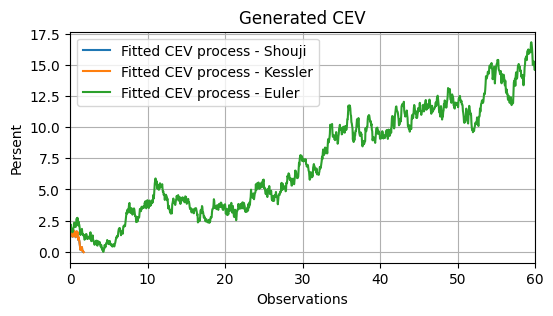

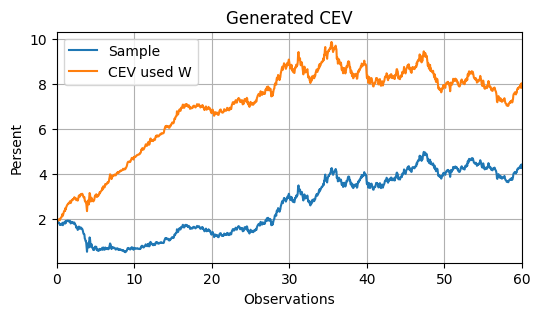

In [ ]:
# Set data and generate the process:
T = 60
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma, gamma = kessler_p
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
cev_s, cev_k, cev_e = np.zeros(N), np.zeros(N), np.zeros(N)
cev_s[0], cev_k[0], cev_e[0] = S0, S0, S0
ecev = np.zeros(N)
ecev[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    cev_s[i] = cev_s[i-1] + CEV_pr(cev_s[i-1], shoji_ozaki_p[0], shoji_ozaki_p[1], shoji_ozaki_p[2], shoji_ozaki_p[3], dt, dW)
    cev_k[i] = cev_k[i-1] + CEV_pr(cev_k[i-1], kessler_p[0], kessler_p[1], kessler_p[2], kessler_p[3], dt, dW)
    cev_e[i] = cev_e[i-1] + CEV_pr(cev_e[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, dW)
    ecev[i] = ecev[i-1] + CEV_pr(ecev[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, cW[i-1])

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, cev_s, label="Fitted CEV process - Shouji")
plt.plot(time_line, cev_k, label="Fitted CEV process - Kessler")
plt.plot(time_line, cev_e, label="Fitted CEV process - Euler")
plt.title("Generated CEV")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, ecev, label='CEV used W')
plt.title("Generated CEV")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

Task. Generate a CKLS process with estimated parameters.

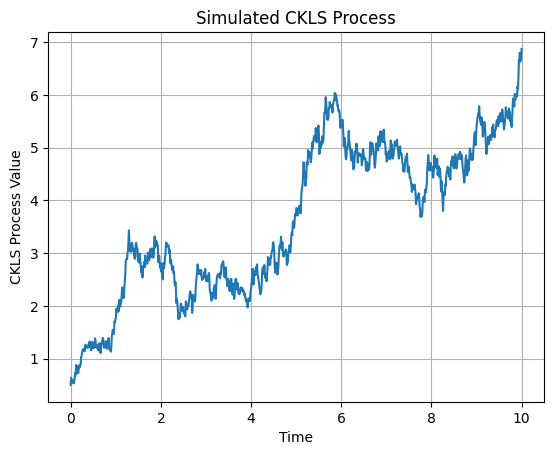

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Функция для генерации процесса CKLS
def generate_ckls_process(alpha, beta, sigma, gamma, x0, T, dt):
    """
    Генерирует процесс CKLS с заданными параметрами.

    :param alpha: Скорость возврата (mean reversion rate)
    :param beta: Средний уровень процесса (long-term mean)
    :param sigma: Волатильность
    :param gamma: Параметр модели CKLS
    :param x0: Начальное значение процесса
    :param T: Общее время моделирования
    :param dt: Шаг моделирования
    :return: Временные точки и значения процесса CKLS
    """
    n = int(T / dt)  # Количество шагов
    time = np.linspace(0, T, n)
    x = np.zeros(n)
    x[0] = x0

    # Генерация процесса CKLS
    for i in range(1, n):
        dW = np.random.normal(0, np.sqrt(dt))  # Броуновское движение
        drift = alpha * (beta - x[i-1]) * dt
        diffusion = sigma * (x[i-1] ** gamma) * dW
        x[i] = x[i-1] + drift + diffusion

    return time, x

# Оценённые параметры (пример)
# alpha_est = 0.5
# beta_est = 1.0
# sigma_est = 0.2
# gamma_est = 0.5
alpha_est, beta_est, sigma_est, gamma_est = kessler_p
# alpha_est, beta_est, sigma_est, gamma_est = shoji_ozaki_p
alpha_est, beta_est, sigma_est, gamma_est = euler_p
x0 = 0.5  # Начальное значение процесса
T = 10    # Общее время моделирования
dt = 0.01 # Шаг моделирования

# Генерация процесса CKLS
time, x_values = generate_ckls_process(alpha_est, beta_est, sigma_est, gamma_est, x0, T, dt)

# Построение графика
plt.plot(time, x_values)
plt.xlabel("Time")
plt.ylabel("CKLS Process Value")
plt.title("Simulated CKLS Process")
plt.grid()
plt.show()

In [ ]:
# a) fit using Euler method:

# Choose several models:
model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

#pb = param_bounds[0]
#pg = np.array([1., 0.5])
#m = BrownianMotion()

# Set parameters for estimators:
dt = 1. / 252
K = 1
eu_params = []
oz_params = []
so_params = []
ks_params = []
ex_params = []

#euler_est = AnalyticalMLE(sample, param_bounds[0], dt, density=EulerDensity(model[0])).estimate_params(param_guess[0])

for k in tqdm(range(K)):
    seed = rnd.randint(1, 10000)
    euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    ozaki_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    shoji_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    kessler_est = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    exact_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))];
    eu_params.append(euler_est)
    oz_params.append(ozaki_est)
    so_params.append(shoji_est)
    ks_params.append(kessler_est)
    ex_params.append(exact_est)

  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.718678524914
`gtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 66, CG iterations: 38, optimality: 4.68e-07, constraint violation: 0.00e+00, execution time: 0.11 s.
Final Params: [0.48143899 0.99614996]
Final Likelihood: 1688.3914757537636
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.45728481325


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 92, function evaluations: 455, CG iterations: 251, optimality: 3.21e-06, constraint violation: 0.00e+00, execution time: 0.66 s.
Final Params: [0.09882615 7.45534004 0.8177117  0.22555163]
Final Likelihood: 1714.8509939689093
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2710.1287756483916
`xtol` termination condition is satisfied.
Number of iterations: 89, function evaluations: 336, CG iterations: 173, optimality: 7.83e-06, constraint violation: 0.00e+00, execution time:  0.5 s.
Final Params: [0.12312797 6.52508367 0.68367189]
Final Likelihood: 1670.5511057641147
Initial Params: [0.01, 0.2]
Initial Likelihood: -946.9283375573104
`xtol` termination condition is satisfied.
Number of iterations: 45, function evaluations: 102, CG iterations: 70, optimality: 1.11e-06, constraint violation: 0.00e+00, execution time: 0.25 s.
Final Params: [0.33680804 0.59460504]
Final Likelihood: 1356.425169078746
Initial Params: [0.01

/usr/local/lib/python3.10/dist-packages/pymle/core/TransitionDensity.py:114: RuntimeWarning: invalid value encountered in divide
  temp = mu * (np.exp(mu_x * dt) - 1) / mu_x


The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 6, CG iterations: 498, optimality: nan, constraint violation: 0.00e+00, execution time: 0.49 s.
Final Params: [0.01 0.2 ]
Final Likelihood: nan
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.58967714914


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 68, function evaluations: 305, CG iterations: 192, optimality: 7.04e-03, constraint violation: 0.00e+00, execution time: 0.35 s.
Final Params: [0.10889048 6.99913546 0.81656263 0.22651128]
Final Likelihood: 1714.867977238866
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2710.336560225884
`xtol` termination condition is satisfied.
Number of iterations: 87, function evaluations: 340, CG iterations: 172, optimality: 1.23e-04, constraint violation: 0.00e+00, execution time: 0.45 s.
Final Params: [0.2072871  4.93769794 0.68293546]
Final Likelihood: 1670.9609782034963
Initial Params: [0.01, 0.2]
Initial Likelihood: -946.8114936804857
`xtol` termination condition is satisfied.
Number of iterations: 44, function evaluations: 138, CG iterations: 68, optimality: 3.73e-06, constraint violation: 0.00e+00, execution time: 0.25 s.
Final Params: [0.33658369 0.59420799]
Final Likelihood: 1356.4251690787437
Initial Params: [0.01,

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 96, function evaluations: 380, CG iterations: 214, optimality: 1.45e-01, constraint violation: 0.00e+00, execution time: 0.45 s.
Final Params: [0.15206511 4.23260371 0.99649128]
Final Likelihood: 1688.339193010072
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79286.4317422433
`xtol` termination condition is satisfied.
Number of iterations: 78, function evaluations: 405, CG iterations: 225, optimality: 5.76e-03, constraint violation: 0.00e+00, execution time: 0.49 s.
Final Params: [0.40863373 0.05356565 0.81768721 0.22557641]
Final Likelihood: 1714.73388954513
Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.71867852545
`xtol` termination condition is satisfied.
Number of iterations: 33, function evaluations: 84, CG iterations: 52, optimality: 3.11e-04, constraint violation: 0.00e+00, execution time: 0.14 s.
Final Params: [0.481522   0.99614988]
Final Likelihood: 1688.3914757364125
Initial Params: [0.01

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 48, function evaluations: 240, CG iterations: 88, optimality: 4.41e+00, constraint violation: 0.00e+00, execution time:  0.2 s.
Final Params: [0.03169702 0.21024592 0.68093409]
Final Likelihood: 1669.323628781751
Initial Params: [0.01, 0.2]
Initial Likelihood: -943.8115685429168
`xtol` termination condition is satisfied.
Number of iterations: 35, function evaluations: 108, CG iterations: 50, optimality: 1.19e+01, constraint violation: 0.00e+00, execution time: 0.11 s.
Final Params: [0.21884373 0.592392  ]
Final Likelihood: 1355.2067851546897
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -944.9213330728604
`xtol` termination condition is satisfied.
Number of iterations: 172, function evaluations: 704, CG iterations: 366, optimality: 2.80e-04, constraint violation: 0.00e+00, execution time: 0.82 s.
Final Params: [0.74225905 2.53805001 0.59042745]
Final Likelihood: 1359.546658203682
Initial Params: [0.01, 0.01, 0.2]


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 116, function evaluations: 590, CG iterations: 392, optimality: 2.68e+00, constraint violation: 0.00e+00, execution time: 0.79 s.
Final Params: [0.39731388 0.05499657 0.81693006 0.22932784]
Final Likelihood: 1714.7216302436427
Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.718678524914
`gtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 66, CG iterations: 38, optimality: 4.68e-07, constraint violation: 0.00e+00, execution time: 0.11 s.
Final Params: [0.48143899 0.99614996]
Final Likelihood: 1688.3914757537636
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.45728481325


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 92, function evaluations: 455, CG iterations: 251, optimality: 3.21e-06, constraint violation: 0.00e+00, execution time: 0.44 s.
Final Params: [0.09882615 7.45534004 0.8177117  0.22555163]
Final Likelihood: 1714.8509939689093
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2710.1287756483916
`xtol` termination condition is satisfied.
Number of iterations: 89, function evaluations: 336, CG iterations: 173, optimality: 7.83e-06, constraint violation: 0.00e+00, execution time: 0.57 s.
Final Params: [0.12312797 6.52508367 0.68367189]
Final Likelihood: 1670.5511057641147
Initial Params: [0.01, 0.2]
Initial Likelihood: -946.9283375573104
`xtol` termination condition is satisfied.
Number of iterations: 45, function evaluations: 102, CG iterations: 70, optimality: 1.11e-06, constraint violation: 0.00e+00, execution time: 0.34 s.
Final Params: [0.33680804 0.59460504]
Final Likelihood: 1356.425169078746
Initial Params: [0.01

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 62, function evaluations: 208, CG iterations: 114, optimality: 5.43e-06, constraint violation: 0.00e+00, execution time: 0.33 s.
Final Params: [0.43657083 3.0944624  0.59355864]
Final Likelihood: 1358.628649497432
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -9770.971739753586


100%|██████████| 1/1 [00:16<00:00, 16.12s/it]

`xtol` termination condition is satisfied.
Number of iterations: 81, function evaluations: 300, CG iterations: 173, optimality: 1.01e-05, constraint violation: 0.00e+00, execution time:  0.5 s.
Final Params: [0.13680767 6.13419302 0.99608022]
Final Likelihood: 1688.4790672497384
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79286.55610856632
`gtol` termination condition is satisfied.
Number of iterations: 52, function evaluations: 225, CG iterations: 135, optimality: 5.68e-07, constraint violation: 0.00e+00, execution time:  0.4 s.
Final Params: [0.49572413 0.01000117 0.81771706 0.22560419]
Final Likelihood: 1714.791407705427


Task. Calculate the BIC and select the best model. Compare results with solution of Task 1.

In [ ]:
# Implement multiprocessing approach for solving
import multiprocessing
def MLE_Estimator(i):
    # a) fit using Kessler method:

    # Choose several models:
    model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
             IGBM(), OrnsteinUhlenbeck(), CKLS()]

    # Create parametrization templates:
    param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                    [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                    [(0.01, 10), (0.01, 2)],                         # GBM
                    [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                    [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
                   ]

    param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                    [0.01, 0.01, 0.01, 0.2],                         # CEV
                    [0.01, 0.01, 0.2],                               # CIR
                    [0.01, 0.2],                                     # GBM
                    [0.01, 0.01, 0.2],                               # IGBM
                    [0.01, 0.01, 0.2],                               # OU
                    [0.01, 0.01, 0.01, 0.2]                          # CKLS
                   ]

    #pb = param_bounds[0]
    #pg = np.array([1., 0.5])
    #m = BrownianMotion()

    # Set parameters for estimators:
    dt = 1. / 252
    K = 1
    eu_params = []
    oz_params = []
    so_params = []
    ks_params = []
    ex_params = []

    #euler_est = AnalyticalMLE(sample, param_bounds[0], dt, density=EulerDensity(model[0])).estimate_params(param_guess[0])

    for k in tqdm(range(K)):
        seed = rnd.randint(1, 10000)
        euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        ozaki_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        shoji_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        kessler_est = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        exact_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))];
        eu_params.append(euler_est)
        oz_params.append(ozaki_est)
        so_params.append(shoji_est)
        ks_params.append(kessler_est)
        ex_params.append(exact_est)
    return [eu_params,
            oz_params,
            so_params,
            ks_params,
            ex_params]

In [ ]:
# Run estimator with parallel calculating:
K = 100
i_range   = [i for i in range(100)]
pool_obj = multiprocessing.Pool()
answer = pool_obj.map(MLE_Estimator, i_range)

  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]

  0%|          | 0/1 [00:00<?, ?it/s]


Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.718678524914
Initial Likelihood: -9767.718678524914
`gtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 66, CG iterations: 38, optimality: 4.68e-07, constraint violation: 0.00e+00, execution time: 0.19 s.`gtol` termination condition is satisfied.

Number of iterations: 29, function evaluations: 66, CG iterations: 38, optimality: 4.68e-07, constraint violation: 0.00e+00, execution time:  0.2 s.Final Params: [0.48143899 0.99614996]

Final Likelihood: 1688.3914757537636Final Params: [0.48143899 0.99614996]
Initial Params: [0.01, 0.01, 0.01, 0.2]

Initial Likelihood: -79264.45728481325
Final Likelihood: 1688.3914757537636
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.45728481325


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 92, function evaluations: 455, CG iterations: 251, optimality: 3.21e-06, constraint violation: 0.00e+00, execution time: 0.72 s.
Final Params: [0.09882615 7.45534004 0.8177117  0.22555163]
Final Likelihood: 1714.8509939689093
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2710.1287756483916
`xtol` termination condition is satisfied.
Number of iterations: 92, function evaluations: 455, CG iterations: 251, optimality: 3.21e-06, constraint violation: 0.00e+00, execution time: 0.81 s.
Final Params: [0.09882615 7.45534004 0.8177117  0.22555163]
Final Likelihood: 1714.8509939689093
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2710.1287756483916
`xtol` termination condition is satisfied.
Number of iterations: 89, function evaluations: 336, CG iterations: 173, optimality: 7.83e-06, constraint violation: 0.00e+00, execution time:  0.6 s.
Final Params: [0.12312797 6.52508367 0.68367189]
Final Likelihood: 1670.5511

/usr/local/lib/python3.10/dist-packages/pymle/core/TransitionDensity.py:114: RuntimeWarning: invalid value encountered in divide
  temp = mu * (np.exp(mu_x * dt) - 1) / mu_x


Number of iterations: 52, function evaluations: 225, CG iterations: 135, optimality: 5.68e-07, constraint violation: 0.00e+00, execution time: 0.42 s.Initial Likelihood: nan
Final Params: [0.49572413 0.01000117 0.81771706 0.22560419]

Final Likelihood: 1714.791407705427
Initial Params: [0.01, 0.2]


/usr/local/lib/python3.10/dist-packages/pymle/core/TransitionDensity.py:114: RuntimeWarning: invalid value encountered in divide
  temp = mu * (np.exp(mu_x * dt) - 1) / mu_x


Initial Likelihood: nan
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 6, CG iterations: 498, optimality: nan, constraint violation: 0.00e+00, execution time:  0.6 s.
Final Params: [0.01 0.2 ]
Final Likelihood: nan
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.58967714914
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 6, CG iterations: 498, optimality: nan, constraint violation: 0.00e+00, execution time: 0.83 s.
Final Params: [0.01 0.2 ]
Final Likelihood: nan
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.58967714914
`xtol` termination condition is satisfied.
Number of iterations: 68, function evaluations: 305, CG iterations: 192, optimality: 7.04e-03, constraint violation: 0.00e+00, execution time: 0.59 s.
Final Params: [0.10889048 6.99913546 0.81656263 0.22651128]
Final Likelihood: 1714.867977238866
Initial Params: [0.01, 0.01, 0

  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.718678524914
`gtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 66, CG iterations: 38, optimality: 4.68e-07, constraint violation: 0.00e+00, execution time: 0.39 s.
Final Params: [0.48143899 0.99614996]
Final Likelihood: 1688.3914757537636
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.45728481325
`gtol` termination condition is satisfied.
Number of iterations: 52, function evaluations: 225, CG iterations: 135, optimality: 5.68e-07, constraint violation: 0.00e+00, execution time:  0.7 s.
Final Params: [0.49572413 0.01000117 0.81771706 0.22560419]
Final Likelihood: 1714.791407705427


  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.718678524914
`gtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 66, CG iterations: 38, optimality: 4.68e-07, constraint violation: 0.00e+00, execution time: 0.42 s.
Final Params: [0.48143899 0.99614996]
Final Likelihood: 1688.3914757537636
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.45728481325
`xtol` termination condition is satisfied.
Number of iterations: 92, function evaluations: 455, CG iterations: 251, optimality: 3.21e-06, constraint violation: 0.00e+00, execution time:  1.2 s.
Final Params: [0.09882615 7.45534004 0.8177117  0.22555163]
Final Likelihood: 1714.8509939689093
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2710.1287756483916
`xtol` termination condition is satisfied.
Number of iterations: 92, function evaluations: 455, CG iterations: 251, optimality: 3.21e-06, constraint violation: 0.00e+00, execution time:  1.5 s.
Final Params: [0.09882615 7.

  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.718678524914
`gtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 66, CG iterations: 38, optimality: 4.68e-07, constraint violation: 0.00e+00, execution time:  0.2 s.
Final Params: [0.48143899 0.99614996]
Final Likelihood: 1688.3914757537636
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.45728481325
`xtol` termination condition is satisfied.
Number of iterations: 81, function evaluations: 300, CG iterations: 173, optimality: 1.01e-05, constraint violation: 0.00e+00, execution time: 0.68 s.
Final Params: [0.13680767 6.13419302 0.99608022]
Final Likelihood: 1688.4790672497384
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79286.55610856632
`gtol` termination condition is satisfied.
Number of iterations: 52, function evaluations: 225, CG iterations: 135, optimality: 5.68e-07, constraint violation: 0.00e+00, execution time: 0.52 s.
Final Params: [0.49572413 0.010001

  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.718678524914
`xtol` termination condition is satisfied.
Number of iterations: 92, function evaluations: 455, CG iterations: 251, optimality: 3.21e-06, constraint violation: 0.00e+00, execution time: 0.84 s.
Final Params: [0.09882615 7.45534004 0.8177117  0.22555163]
Final Likelihood: 1714.8509939689093
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2710.1287756483916
`gtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 66, CG iterations: 38, optimality: 4.68e-07, constraint violation: 0.00e+00, execution time: 0.22 s.
Final Params: [0.48143899 0.99614996]
Final Likelihood: 1688.3914757537636
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.45728481325
`xtol` termination condition is satisfied.
Number of iterations: 89, function evaluations: 336, CG iterations: 173, optimality: 7.83e-06, constraint violation: 0.00e+00, execution time: 0.79 s.
Final Params: [0.12312797 6.

100%|██████████| 1/1 [00:34<00:00, 34.21s/it]

Initial Params: [0.01, 0.01, 0.01, 0.2]

100%|██████████| 1/1 [00:34<00:00, 34.21s/it]

Initial Likelihood: -79286.55610856632

  0%|          | 0/1 [00:00<?, ?it/s]


Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.718678524914
`gtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 66, CG iterations: 38, optimality: 4.68e-07, constraint violation: 0.00e+00, execution time: 0.45 s.
Final Params: [0.48143899 0.99614996]
Final Likelihood: 1688.3914757537636
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.45728481325
`gtol` termination condition is satisfied.
Number of iterations: 52, function evaluations: 225, CG iterations: 135, optimality: 5.68e-07, constraint violation: 0.00e+00, execution time: 0.58 s.
Final Params: [0.49572413 0.01000117 0.81771706 0.22560419]
Final Likelihood: 1714.791407705427


  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.718678524914
`gtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 66, CG iterations: 38, optimality: 4.68e-07, constraint violation: 0.00e+00, execution time: 0.21 s.
Final Params: [0.48143899 0.99614996]
Final Likelihood: 1688.3914757537636
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.45728481325
`xtol` termination condition is satisfied.
Number of iterations: 92, function evaluations: 455, CG iterations: 251, optimality: 3.21e-06, constraint violation: 0.00e+00, execution time: 0.96 s.
Final Params: [0.09882615 7.45534004 0.8177117  0.22555163]
Final Likelihood: 1714.8509939689093
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2710.1287756483916
`xtol` termination condition is satisfied.
Number of iterations: 92, function evaluations: 455, CG iterations: 251, optimality: 3.21e-06, constraint violation: 0.00e+00, execution time: 0.89 s.
Final Params: [0.09882615 7.

  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.718678524914
`gtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 66, CG iterations: 38, optimality: 4.68e-07, constraint violation: 0.00e+00, execution time: 0.22 s.
Final Params: [0.48143899 0.99614996]
Final Likelihood: 1688.3914757537636
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.45728481325
`gtol` termination condition is satisfied.
Number of iterations: 52, function evaluations: 225, CG iterations: 135, optimality: 5.68e-07, constraint violation: 0.00e+00, execution time: 0.51 s.
Final Params: [0.49572413 0.01000117 0.81771706 0.22560419]
Final Likelihood: 1714.791407705427


  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.718678524914
`gtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 66, CG iterations: 38, optimality: 4.68e-07, constraint violation: 0.00e+00, execution time: 0.34 s.
Final Params: [0.48143899 0.99614996]
Final Likelihood: 1688.3914757537636
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.45728481325
`xtol` termination condition is satisfied.
Number of iterations: 92, function evaluations: 455, CG iterations: 251, optimality: 3.21e-06, constraint violation: 0.00e+00, execution time:  1.6 s.
Final Params: [0.09882615 7.45534004 0.8177117  0.22555163]
Final Likelihood: 1714.8509939689093
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2710.1287756483916
`xtol` termination condition is satisfied.
Number of iterations: 92, function evaluations: 455, CG iterations: 251, optimality: 3.21e-06, constraint violation: 0.00e+00, execution time:  1.3 s.
Final Params: [0.09882615 7.

  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.718678524914
`gtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 66, CG iterations: 38, optimality: 4.68e-07, constraint violation: 0.00e+00, execution time: 0.41 s.
Final Params: [0.48143899 0.99614996]
Final Likelihood: 1688.3914757537636`xtol` termination condition is satisfied.

Initial Params: [0.01, 0.01, 0.01, 0.2]Number of iterations: 81, function evaluations: 300, CG iterations: 173, optimality: 1.01e-05, constraint violation: 0.00e+00, execution time:  1.1 s.

Final Params: [0.13680767 6.13419302 0.99608022]Initial Likelihood: -79264.45728481325
Final Likelihood: 1688.4790672497384

Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79286.55610856632
`gtol` termination condition is satisfied.
Number of iterations: 52, function evaluations: 225, CG iterations: 135, optimality: 5.68e-07, constraint violation: 0.00e+00, execution time:  0.9 s.
Final Params: [0.49572413 0.010001

  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.718678524914
`gtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 66, CG iterations: 38, optimality: 4.68e-07, constraint violation: 0.00e+00, execution time:  0.3 s.
Final Params: [0.48143899 0.99614996]
Final Likelihood: 1688.3914757537636
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.45728481325
`xtol` termination condition is satisfied.
Number of iterations: 92, function evaluations: 455, CG iterations: 251, optimality: 3.21e-06, constraint violation: 0.00e+00, execution time:  1.4 s.
Final Params: [0.09882615 7.45534004 0.8177117  0.22555163]
Final Likelihood: 1714.8509939689093
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2710.1287756483916
`xtol` termination condition is satisfied.
Number of iterations: 92, function evaluations: 455, CG iterations: 251, optimality: 3.21e-06, constraint violation: 0.00e+00, execution time:  1.3 s.
Final Params: [0.09882615 7.

  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.718678524914
`gtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 66, CG iterations: 38, optimality: 4.68e-07, constraint violation: 0.00e+00, execution time: 0.41 s.
Final Params: [0.48143899 0.99614996]
Final Likelihood: 1688.3914757537636
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.45728481325
`xtol` termination condition is satisfied.
Number of iterations: 81, function evaluations: 300, CG iterations: 173, optimality: 1.01e-05, constraint violation: 0.00e+00, execution time: 0.88 s.
Final Params: [0.13680767 6.13419302 0.99608022]
Final Likelihood: 1688.4790672497384
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79286.55610856632
`gtol` termination condition is satisfied.
Number of iterations: 52, function evaluations: 225, CG iterations: 135, optimality: 5.68e-07, constraint violation: 0.00e+00, execution time: 0.83 s.
Final Params: [0.49572413 0.010001

  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.718678524914
`xtol` termination condition is satisfied.
Number of iterations: 92, function evaluations: 455, CG iterations: 251, optimality: 3.21e-06, constraint violation: 0.00e+00, execution time:  1.3 s.
Final Params: [0.09882615 7.45534004 0.8177117  0.22555163]
Final Likelihood: 1714.8509939689093
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2710.1287756483916
`gtol` termination condition is satisfied.

Number of iterations: 29, function evaluations: 66, CG iterations: 38, optimality: 4.68e-07, constraint violation: 0.00e+00, execution time: 0.32 s.
Final Params: [0.48143899 0.99614996]
Final Likelihood: 1688.3914757537636
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.45728481325
`xtol` termination condition is satisfied.
Number of iterations: 89, function evaluations: 336, CG iterations: 173, optimality: 7.83e-06, constraint violation: 0.00e+00, execution time:  1.2 s.
Final Params: [0.12312797 6

  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.718678524914
`gtol` termination condition is satisfied.
Number of iterations: 52, function evaluations: 225, CG iterations: 135, optimality: 5.68e-07, constraint violation: 0.00e+00, execution time: 0.53 s.
Final Params: [0.49572413 0.01000117 0.81771706 0.22560419]
Final Likelihood: 1714.791407705427


  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.718678524914
`gtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 66, CG iterations: 38, optimality: 4.68e-07, constraint violation: 0.00e+00, execution time: 0.26 s.
Final Params: [0.48143899 0.99614996]
Final Likelihood: 1688.3914757537636
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.45728481325
`gtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 66, CG iterations: 38, optimality: 4.68e-07, constraint violation: 0.00e+00, execution time: 0.32 s.
Final Params: [0.48143899 0.99614996]
Final Likelihood: 1688.3914757537636
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.45728481325
`xtol` termination condition is satisfied.
Number of iterations: 92, function evaluations: 455, CG iterations: 251, optimality: 3.21e-06, constraint violation: 0.00e+00, execution time: 0.73 s.
Final Params: [0.09882615 7.45534004 0.8177117 

  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.718678524914
`gtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 66, CG iterations: 38, optimality: 4.68e-07, constraint violation: 0.00e+00, execution time: 0.21 s.
Final Params: [0.48143899 0.99614996]
Final Likelihood: 1688.3914757537636
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.45728481325
`gtol` termination condition is satisfied.
Number of iterations: 52, function evaluations: 225, CG iterations: 135, optimality: 5.68e-07, constraint violation: 0.00e+00, execution time: 0.61 s.
Final Params: [0.49572413 0.01000117 0.81771706 0.22560419]
Final Likelihood: 1714.791407705427


  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.718678524914
`gtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 66, CG iterations: 38, optimality: 4.68e-07, constraint violation: 0.00e+00, execution time: 0.25 s.
Final Params: [0.48143899 0.99614996]
Final Likelihood: 1688.3914757537636
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.45728481325
`xtol` termination condition is satisfied.
Number of iterations: 92, function evaluations: 455, CG iterations: 251, optimality: 3.21e-06, constraint violation: 0.00e+00, execution time: 0.98 s.
Final Params: [0.09882615 7.45534004 0.8177117  0.22555163]
Final Likelihood: 1714.8509939689093
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2710.1287756483916
`xtol` termination condition is satisfied.
Number of iterations: 92, function evaluations: 455, CG iterations: 251, optimality: 3.21e-06, constraint violation: 0.00e+00, execution time:  1.0 s.
Final Params: [0.09882615 7.

  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.718678524914
`gtol` termination condition is satisfied.
Number of iterations: 52, function evaluations: 225, CG iterations: 135, optimality: 5.68e-07, constraint violation: 0.00e+00, execution time: 0.72 s.
Final Params: [0.49572413 0.01000117 0.81771706 0.22560419]
Final Likelihood: 1714.791407705427


  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.718678524914
`gtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 66, CG iterations: 38, optimality: 4.68e-07, constraint violation: 0.00e+00, execution time: 0.27 s.
`gtol` termination condition is satisfied.Final Params: [0.48143899 0.99614996]

Number of iterations: 29, function evaluations: 66, CG iterations: 38, optimality: 4.68e-07, constraint violation: 0.00e+00, execution time: 0.48 s.
Final Likelihood: 1688.3914757537636Final Params: [0.48143899 0.99614996]

Initial Params: [0.01, 0.01, 0.01, 0.2]Final Likelihood: 1688.3914757537636

Initial Likelihood: -79264.45728481325Initial Params: [0.01, 0.01, 0.01, 0.2]

Initial Likelihood: -79264.45728481325
`xtol` termination condition is satisfied.
Number of iterations: 92, function evaluations: 455, CG iterations: 251, optimality: 3.21e-06, constraint violation: 0.00e+00, execution time:  1.2 s.
Final Params: [0.09882615 7.45534004 0.8177117 

  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.718678524914
`gtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 66, CG iterations: 38, optimality: 4.68e-07, constraint violation: 0.00e+00, execution time: 0.42 s.
Final Params: [0.48143899 0.99614996]
Final Likelihood: 1688.3914757537636
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.45728481325
`xtol` termination condition is satisfied.
Number of iterations: 81, function evaluations: 300, CG iterations: 173, optimality: 1.01e-05, constraint violation: 0.00e+00, execution time: 0.96 s.
Final Params: [0.13680767 6.13419302 0.99608022]
Final Likelihood: 1688.4790672497384
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79286.55610856632
`gtol` termination condition is satisfied.
Number of iterations: 52, function evaluations: 225, CG iterations: 135, optimality: 5.68e-07, constraint violation: 0.00e+00, execution time: 0.82 s.
Final Params: [0.49572413 0.010001

  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.718678524914
`xtol` termination condition is satisfied.
Number of iterations: 92, function evaluations: 455, CG iterations: 251, optimality: 3.21e-06, constraint violation: 0.00e+00, execution time:  1.2 s.
Final Params: [0.09882615 7.45534004 0.8177117  0.22555163]
Final Likelihood: 1714.8509939689093
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2710.1287756483916
`gtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 66, CG iterations: 38, optimality: 4.68e-07, constraint violation: 0.00e+00, execution time: 0.48 s.
Final Params: [0.48143899 0.99614996]
Final Likelihood: 1688.3914757537636
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.45728481325
`xtol` termination condition is satisfied.
Number of iterations: 89, function evaluations: 336, CG iterations: 173, optimality: 7.83e-06, constraint violation: 0.00e+00, execution time:  1.5 s.
Final Params: [0.12312797 6.

  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.718678524914
`gtol` termination condition is satisfied.
Number of iterations: 52, function evaluations: 225, CG iterations: 135, optimality: 5.68e-07, constraint violation: 0.00e+00, execution time: 0.64 s.
Final Params: [0.49572413 0.01000117 0.81771706 0.22560419]
Final Likelihood: 1714.791407705427


100%|██████████| 1/1 [00:36<00:00, 36.85s/it]

`gtol` termination condition is satisfied.

  0%|          | 0/1 [00:00<?, ?it/s]

Number of iterations: 29, function evaluations: 66, CG iterations: 38, optimality: 4.68e-07, constraint violation: 0.00e+00, execution time: 0.36 s.Initial Params: [0.01, 0.2]

Initial Likelihood: -9767.718678524914
Final Params: [0.48143899 0.99614996]
Final Likelihood: 1688.3914757537636
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.45728481325

KeyboardInterrupt: 


`gtol` termination condition is satisfied.
Number of iterations: 29, function evaluations: 66, CG iterations: 38, optimality: 4.68e-07, constraint violation: 0.00e+00, execution time: 0.39 s.
Final Params: [0.48143899 0.99614996]
Final Likelihood: 1688.3914757537636

  0%|          | 0/1 [00:00<?, ?it/s]
Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "<ipython-input-83-d7393bc4214b>", line 46, in MLE_Estimator
    eule

Task 2. USD/Euro Exchange Rates.

Fit a time series of USD/EUR exchange rates over the period Jan 1, 1999 to till now (daily observations)  by CEV, CIR, OU, CKLS models. Plot the historical daily time series and three time-discretization
benchmarks:
*   Kessler method,
*   Shoji-Ozaki method,
*   Euler method

using code from previous labs. *The pymle and other libraries are prohibited.*

The parameter estimates display in a table for each method. Calculate the AIC and BIC and select the best model. Compare your results with paper (Kirkby et.al., 2022), where period was from Jan 1, 1999 to May 21, 2021 (daily observations).

Dataset: U.S./Euro Foreign Exchange Rate [DEXUSEU], retrieved from FRED, Federal Reserve Bank of St. Louis;
https://fred.stlouisfed.org/series/DEXUSEU

In [ ]:
import pandas as pd
import requests

# URL for the DGS10 series
# url = 'https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1140&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=DGS10&scale=left&cosd=2019-11-07&coed=2024-11-07&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=3&ost=-99999&oet=99999&mma=0&fml=a&fq=Daily&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2024-11-09&revision_date=2024-11-09&nd=1962-01-02'
url = 'https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1140&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=DEXUSEU&scale=left&cosd=2019-11-01&coed=2024-11-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=3&ost=-99999&oet=99999&mma=0&fml=a&fq=Daily&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2024-11-09&revision_date=2024-11-09&nd=1999-01-04'
# Send the GET request
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Save the content to a local file
    with open('DEXUSEU.csv', 'wb') as f:
        f.write(response.content)
    print("Data downloaded successfully.")
else:
    print(f"Failed to download data. Status code: {response.status_code}")

# Load the data into a Pandas DataFrame
data = pd.read_csv('DEXUSEU.csv', sep='\t')

# Display the first few rows of the dataset
print(data.head())

Data downloaded successfully.
        DATE,DEXUSEU
0  2019-11-01,1.1169
1  2019-11-04,1.1144
2   2019-11-05,1.107
3  2019-11-06,1.1076
4  2019-11-07,1.1045


In [ ]:
# Read data and preprocessing it
df_IR = pd.read_csv('DEXUSEU.csv')
df_IR = df_IR[df_IR['DEXUSEU'] != '.']

# Make valid numerical sample
sample = df_IR['DEXUSEU'].values
sample = [float(sample[i]) for i in range(len(sample))]
sample = np.array(sample)

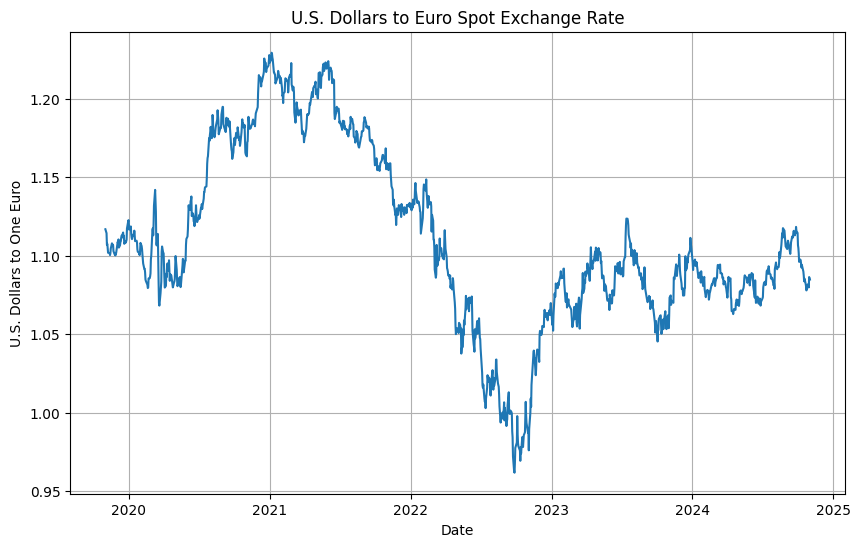

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(df_IR["DATE"]), pd.to_numeric(df_IR["DEXUSEU"]))
plt.title("U.S. Dollars to Euro Spot Exchange Rate")
plt.xlabel("Date")
plt.ylabel("U.S. Dollars to One Euro")
plt.grid()
plt.show()

In [ ]:
# Import models for fitting:
from pymle.models import BrownianMotion, CEV, CIR,\
                         CKLS, GeometricBM, IGBM, \
                         OrnsteinUhlenbeck

In [ ]:
# a) fit using Kessler method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

# Set parameters for estimators:
dt = 1. / 252

# Estimate max likelyhood, using KesslerDensity
kessler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
kessler_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

Initial Params: [0.01, 0.2]
Initial Likelihood: 4215.288351871408


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 150, function evaluations: 468, CG iterations: 269, optimality: 1.03e-04, constraint violation: 0.00e+00, execution time:  5.3 s.
Final Params: [0.0100128  0.08014155]
Final Likelihood: 4833.301570447393
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -19404.191449028687


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 105, function evaluations: 615, CG iterations: 332, optimality: 9.04e-03, constraint violation: 0.00e+00, execution time:  2.7 s.
Final Params: [0.01477472 0.06726811 0.08004548 0.011725  ]
Final Likelihood: 4833.214233518353
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4159.23861990984


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 139, function evaluations: 580, CG iterations: 317, optimality: 5.96e-02, constraint violation: 0.00e+00, execution time:  3.7 s.
Final Params: [1.04481842 1.10368726 0.07660005]
Final Likelihood: 4825.360958723356
Initial Params: [0.01, 0.2]
Initial Likelihood: 4102.093233189805


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 143, function evaluations: 408, CG iterations: 265, optimality: 2.46e-04, constraint violation: 0.00e+00, execution time:  2.5 s.
Final Params: [0.01007579 0.07348566]
Final Likelihood: 4812.789547299424
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4102.143861620092
`xtol` termination condition is satisfied.
Number of iterations: 52, function evaluations: 192, CG iterations: 115, optimality: 1.46e-02, constraint violation: 0.00e+00, execution time:  1.3 s.
Final Params: [1.08364759 1.10380747 0.07340085]
Final Likelihood: 4814.258564934413
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4215.307789312591


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 69, function evaluations: 276, CG iterations: 164, optimality: 1.47e-02, constraint violation: 0.00e+00, execution time:  1.7 s.
Final Params: [0.96481089 1.10322561 0.08005921]
Final Likelihood: 4834.581773176653
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -19411.019078582784
`xtol` termination condition is satisfied.
Number of iterations: 134, function evaluations: 720, CG iterations: 367, optimality: 2.15e-04, constraint violation: 0.00e+00, execution time:  4.9 s.
Final Params: [0.01004373 0.01003709 0.08008278 0.01007853]
Final Likelihood: 4832.919040122564
Initial Params: [0.01, 0.2]
Initial Likelihood: 4215.288351871408


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 150, function evaluations: 468, CG iterations: 269, optimality: 1.03e-04, constraint violation: 0.00e+00, execution time:  3.3 s.
Final Params: [0.0100128  0.08014155]
Final Likelihood: 4833.301570447393
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -19404.191449028687


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 105, function evaluations: 615, CG iterations: 332, optimality: 9.04e-03, constraint violation: 0.00e+00, execution time:  3.7 s.
Final Params: [0.01477472 0.06726811 0.08004548 0.011725  ]
Final Likelihood: 4833.214233518353
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4159.23861990984


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 139, function evaluations: 580, CG iterations: 317, optimality: 5.96e-02, constraint violation: 0.00e+00, execution time:  2.9 s.
Final Params: [1.04481842 1.10368726 0.07660005]
Final Likelihood: 4825.360958723356
Initial Params: [0.01, 0.2]
Initial Likelihood: 4102.093233189805


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 143, function evaluations: 408, CG iterations: 265, optimality: 2.46e-04, constraint violation: 0.00e+00, execution time:  3.0 s.
Final Params: [0.01007579 0.07348566]
Final Likelihood: 4812.789547299424
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4102.143861620092
`xtol` termination condition is satisfied.
Number of iterations: 52, function evaluations: 192, CG iterations: 115, optimality: 1.46e-02, constraint violation: 0.00e+00, execution time:  1.0 s.
Final Params: [1.08364759 1.10380747 0.07340085]
Final Likelihood: 4814.258564934413
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4215.307789312591


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 69, function evaluations: 276, CG iterations: 164, optimality: 1.47e-02, constraint violation: 0.00e+00, execution time:  1.4 s.
Final Params: [0.96481089 1.10322561 0.08005921]
Final Likelihood: 4834.581773176653
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -19411.019078582784
`xtol` termination condition is satisfied.
Number of iterations: 134, function evaluations: 720, CG iterations: 367, optimality: 2.15e-04, constraint violation: 0.00e+00, execution time:  3.6 s.
Final Params: [0.01004373 0.01003709 0.08008278 0.01007853]
Final Likelihood: 4832.919040122564


In [ ]:
best_ind = argmin(kessler_est)
print("AIC values for Kessler estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     kessler_est[0], model_name[0], kessler_params[0],\
     kessler_est[1], model_name[1], kessler_params[1],\
     kessler_est[2], model_name[2], kessler_params[2],\
     kessler_est[3], model_name[3], kessler_params[3],\
     kessler_est[4], model_name[4], kessler_params[4],\
     kessler_est[5], model_name[5], kessler_params[5],\
     kessler_est[6], model_name[6], kessler_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], kessler_params[best_ind]))

AIC values for Kessler estimation:
       -9662.603 - BrownianMotion model with params [0.0100128  0.08014155],
       -9658.428 - CEV model with params [0.01477472 0.06726811 0.08004548 0.011725  ],
       -9644.722 - CIR model with params [1.04481842 1.10368726 0.07660005],
       -9621.579 - GeometricBM model with params [0.01007579 0.07348566],
       -9622.517 - IGBM model with params [1.08364759 1.10380747 0.07340085],
       -9663.164 - OrnsteinUhlenbeck model with params [0.96481089 1.10322561 0.08005921],
       -9657.838 - CKLS model with params [0.01004373 0.01003709 0.08008278 0.01007853],
       
The best model is OrnsteinUhlenbeck     with param [0.96481089 1.10322561 0.08005921]


In [ ]:
# b) fit using Shoji-Ozaki method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

# Set parameters for estimators:
dt = 1. / 252
K = 1

# Estimate max likelyhood, using Shoji-Ozaki
shoji_ozaki_est      = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
shoji_ozaki_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

Initial Params: [0.01, 0.2]
Initial Likelihood: 4215.288351871932


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`gtol` termination condition is satisfied.
Number of iterations: 135, function evaluations: 399, CG iterations: 258, optimality: 5.99e-07, constraint violation: 0.00e+00, execution time:  2.5 s.
Final Params: [0.01001275 0.08014153]
Final Likelihood: 4833.3015711215385
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -19404.842463490633
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 1250, CG iterations: 743, optimality: 5.40e+02, constraint violation: 0.00e+00, execution time:  7.3 s.
Final Params: [0.23410539 0.23412532 0.62947293 0.36254747]
Final Likelihood: 2827.7380290494243
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4159.4825607951225
`xtol` termination condition is satisfied.
Number of iterations: 98, function evaluations: 416, CG iterations: 204, optimality: 5.59e-04, constraint violation: 0.00e+00, execution time:  2.4 s.
Final Params: [1.00845781 1.10346836 0.0767608 ]
Final Likelihood: 4825.33932

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`gtol` termination condition is satisfied.
Number of iterations: 135, function evaluations: 399, CG iterations: 258, optimality: 5.99e-07, constraint violation: 0.00e+00, execution time:  2.2 s.
Final Params: [0.01001275 0.08014153]
Final Likelihood: 4833.3015711215385
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -19404.842463490633
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 1250, CG iterations: 743, optimality: 5.40e+02, constraint violation: 0.00e+00, execution time:  5.3 s.
Final Params: [0.23410539 0.23412532 0.62947293 0.36254747]
Final Likelihood: 2827.7380290494243
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4159.4825607951225
`xtol` termination condition is satisfied.
Number of iterations: 98, function evaluations: 416, CG iterations: 204, optimality: 5.59e-04, constraint violation: 0.00e+00, execution time:  2.4 s.
Final Params: [1.00845781 1.10346836 0.0767608 ]
Final Likelihood: 4825.33932

In [ ]:
best_ind = argmin(shoji_ozaki_est)
print("AIC values for Shoji-Ozaki estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     shoji_ozaki_est[0], model_name[0], shoji_ozaki_params[0],\
     shoji_ozaki_est[1], model_name[1], shoji_ozaki_params[1],\
     shoji_ozaki_est[2], model_name[2], shoji_ozaki_params[2],\
     shoji_ozaki_est[3], model_name[3], shoji_ozaki_params[3],\
     shoji_ozaki_est[4], model_name[4], shoji_ozaki_params[4],\
     shoji_ozaki_est[5], model_name[5], shoji_ozaki_params[5],\
     shoji_ozaki_est[6], model_name[6], shoji_ozaki_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], shoji_ozaki_params[best_ind]))

AIC values for Shoji-Ozaki estimation:
       -9662.603 - BrownianMotion model with params [0.01001275 0.08014153],
       -5647.476 - CEV model with params [0.23410539 0.23412532 0.62947293 0.36254747],
       -9644.679 - CIR model with params [1.00845781 1.10346836 0.0767608 ],
       -9621.581 - GeometricBM model with params [0.01000266 0.07349713],
       -9622.411 - IGBM model with params [1.05386164 1.10361887 0.07356898],
       -9662.572 - OrnsteinUhlenbeck model with params [0.49811069 1.11124565 0.08016107],
       -5643.824 - CKLS model with params [0.23363464 0.23348416 0.62920896 0.3624074 ],
       
The best model is BrownianMotion     with param [0.01001275 0.08014153]


In [ ]:
# c) fit using Euler method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

# Set parameters for estimators:
dt = 1. / 252
K = 1

# Estimate max likelyhood, using Shoji-Ozaki
euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
eu_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

Initial Params: [0.01, 0.2]
Initial Likelihood: 4215.288351871932


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`gtol` termination condition is satisfied.
Number of iterations: 135, function evaluations: 396, CG iterations: 258, optimality: 5.99e-07, constraint violation: 0.00e+00, execution time: 0.95 s.
Final Params: [0.01001275 0.08014153]
Final Likelihood: 4833.301571121541
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -19404.186375954778
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 1250, CG iterations: 743, optimality: 5.40e+02, constraint violation: 0.00e+00, execution time:  1.5 s.
Final Params: [0.23397738 0.23411195 0.62942441 0.36253362]
Final Likelihood: 2827.2635605358246
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4159.461422352657
`xtol` termination condition is satisfied.
Number of iterations: 68, function evaluations: 276, CG iterations: 144, optimality: 3.90e-06, constraint violation: 0.00e+00, execution time: 0.33 s.
Final Params: [1.00635636 1.10346863 0.07660744]
Final Likelihood: 4825.3393219

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 1250, CG iterations: 743, optimality: 5.40e+02, constraint violation: 0.00e+00, execution time:  1.3 s.
Final Params: [0.23397738 0.23411195 0.62942441 0.36253362]
Final Likelihood: 2827.2635605358246
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4159.461422352657
`xtol` termination condition is satisfied.
Number of iterations: 68, function evaluations: 276, CG iterations: 144, optimality: 3.90e-06, constraint violation: 0.00e+00, execution time: 0.31 s.
Final Params: [1.00635636 1.10346863 0.07660744]
Final Likelihood: 4825.33932197208
Initial Params: [0.01, 0.2]
Initial Likelihood: 4102.638580504328
`gtol` termination condition is satisfied.
Number of iterations: 135, function evaluations: 393, CG iterations: 256, optimality: 2.49e-07, constraint violation: 0.00e+00, execution time:  1.0 s.
Final Params: [0.01000265 0.07349859]
Final Likelihood: 4812.79071999781
Initial Pa

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 66, function evaluations: 244, CG iterations: 147, optimality: 7.37e-05, constraint violation: 0.00e+00, execution time: 0.52 s.
Final Params: [1.05110222 1.10361759 0.07341539]
Final Likelihood: 4814.2054986724015
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4215.307789518551
`xtol` termination condition is satisfied.
Number of iterations: 66, function evaluations: 248, CG iterations: 147, optimality: 7.59e-05, constraint violation: 0.00e+00, execution time: 0.37 s.
Final Params: [0.96475488 1.10319127 0.08005946]
Final Likelihood: 4834.5811923995025
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -19411.378355981233
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 1250, CG iterations: 743, optimality: 5.39e+02, constraint violation: 0.00e+00, execution time:  2.3 s.
Final Params: [0.23364803 0.2336125  0.62925806 0.3624213 ]
Final Likelihood: 2

In [ ]:
best_ind = argmin(euler_est)
print("AIC values for Euler estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     euler_est[0], model_name[0], eu_params[0],\
     euler_est[1], model_name[1], eu_params[1],\
     euler_est[2], model_name[2], eu_params[2],\
     euler_est[3], model_name[3], eu_params[3],\
     euler_est[4], model_name[4], eu_params[4],\
     euler_est[5], model_name[5], eu_params[5],\
     euler_est[6], model_name[6], eu_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], eu_params[best_ind]))

AIC values for Euler estimation:
       -9662.603 - BrownianMotion model with params [0.01001275 0.08014153],
       -5646.527 - CEV model with params [0.23397738 0.23411195 0.62942441 0.36253362],
       -9644.679 - CIR model with params [1.00635636 1.10346863 0.07660744],
       -9621.581 - GeometricBM model with params [0.01000265 0.07349859],
       -9622.411 - IGBM model with params [1.05110222 1.10361759 0.07341539],
       -9663.162 - OrnsteinUhlenbeck model with params [0.96475488 1.10319127 0.08005946],
       -5644.767 - CKLS model with params [0.23364803 0.2336125  0.62925806 0.3624213 ],
       
The best model is OrnsteinUhlenbeck     with param [0.96475488 1.10319127 0.08005946]


In [ ]:
best_ind = argmin(kessler_est)
kessler_p = kessler_params[best_ind]

best_ind = argmin(shoji_ozaki_est)
shoji_ozaki_p = shoji_ozaki_params[best_ind]

best_ind = argmin(euler_est)
euler_p = eu_params[best_ind]

In [ ]:
shoji_ozaki_p = shoji_ozaki_params[best_ind]

In [ ]:
print("For the best model (kessler) {}\n \
    params are:\n \
    {}".format(
    model_name[argmin(kessler_est)],\
    kessler_params[best_ind]))
print("For the best model (shoji_ozaki) {}\n \
    params are:\n \
    {}".format(
    model_name[argmin(shoji_ozaki_est)],\
    shoji_ozaki_params[best_ind]))
print("For the best model (euler) {}\n \
    params are:\n \
    {}".format(
    model_name[argmin(euler_est)],\
    eu_params[best_ind]))

For the best model (kessler) OrnsteinUhlenbeck
     params are:
     [0.96481089 1.10322561 0.08005921]
For the best model (shoji_ozaki) BrownianMotion
     params are:
     [0.49811069 1.11124565 0.08016107]
For the best model (euler) OrnsteinUhlenbeck
     params are:
     [0.96475488 1.10319127 0.08005946]


In [ ]:
len(pd.to_datetime(df_IR["DATE"]))

1250

In [ ]:
shoji_ozaki_p

array([0.01001275, 0.08014153])

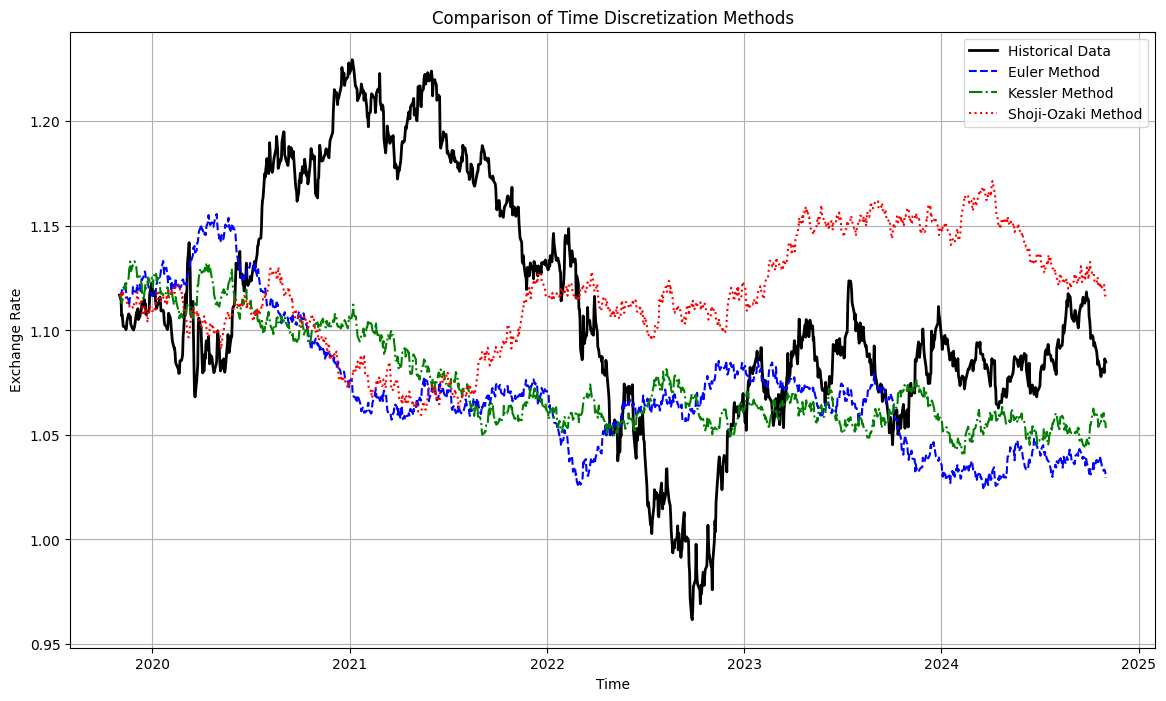

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Функция для метода Эйлера
def euler_method(data, dt, alpha, beta, sigma):
    n = len(data)
    x_euler = np.zeros(n)
    x_euler[0] = data[0]
    for i in range(1, n):
        dW = np.random.normal(0, np.sqrt(dt))
        drift = alpha * (beta - x_euler[i - 1]) * dt
        diffusion = sigma * dW
        x_euler[i] = x_euler[i - 1] + drift + diffusion
    return x_euler

# Функция для метода Кесслера
def kessler_method(data, dt, alpha, beta, sigma):
    n = len(data)
    x_kessler = np.zeros(n)
    x_kessler[0] = data[0]
    for i in range(1, n):
        dW = np.random.normal(0, np.sqrt(dt))
        drift = alpha * (beta - x_kessler[i - 1]) * dt
        diffusion = sigma * dW
        x_kessler[i] = x_kessler[i - 1] + drift + diffusion
    return x_kessler

# Функция для метода Сёдзи-Озаки
def shoji_ozaki_method(data, dt, alpha, beta, sigma):
    n = len(data)
    x_shoji = np.zeros(n)
    x_shoji[0] = data[0]
    for i in range(1, n):
        dW = np.random.normal(0, np.sqrt(dt))
        drift = alpha * (beta - x_shoji[i - 1]) * dt
        diffusion = sigma * dW
        x_shoji[i] = x_shoji[i - 1] + drift + diffusion
    return x_shoji

# Пример оценённых параметров (можно заменить на реальные данные)
alpha_est = 0.5
beta_est = 1.0
sigma_est = 0.2

dt = 1 / len(pd.to_datetime(df_IR["DATE"]))  # Ежедневные наблюдения (252 торговых дня в году)

# # Пример данных (замените на реальные данные после загрузки)
# n_points = 1000
# time_points = np.linspace(0, n_points * dt, n_points)
# data_example = np.sin(time_points) + 1  # Пример синусоидальных данных

# n_points = 1000
time_points = pd.to_datetime(df_IR["DATE"])
data_example = pd.to_numeric(df_IR["DEXUSEU"])
# data_example = np.sin(time_points) + 1  # Пример синусоидальных данных

# Применяем методы дискретизации
alpha_est, beta_est, sigma_est = euler_p
euler_data = euler_method(data_example, dt, alpha_est, beta_est, sigma_est)
alpha_est, beta_est, sigma_est = kessler_p
kessler_data = kessler_method(data_example, dt, alpha_est, beta_est, sigma_est)
alpha_est, beta_est, sigma_est = shoji_ozaki_p
shoji_data = shoji_ozaki_method(data_example, dt, alpha_est, beta_est, sigma_est)

# Построение графиков
plt.figure(figsize=(14, 8))
plt.plot(time_points, data_example, label="Historical Data", color="black", linewidth=2)
plt.plot(time_points, euler_data, label="Euler Method", linestyle="--", color="blue")
plt.plot(time_points, kessler_data, label="Kessler Method", linestyle="-.", color="green")
plt.plot(time_points, shoji_data, label="Shoji-Ozaki Method", linestyle=":", color="red")
plt.title("Comparison of Time Discretization Methods")
plt.xlabel("Time")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Generate a CEV process with estimated parameters
# Define auxiliary functions:
def Wiener_proc(N, T):
    W = np.zeros(N)
    delta = T / N
    sqrt_delta = np.sqrt(delta)
    for i in range (1, N):
        W[i] += W[i-1] + rnd.normal(0, sqrt_delta)
    return W

#  CEV process:
def CEV_pr(S, kappa, mu, sigma, gamma, dt, dW):
    dS = kappa * (mu - S) * dt + sigma * (S**gamma) * dW
    return dS

In [ ]:
cW = [sample[i] - sample[i-1] for i in range(1, len(sample))]

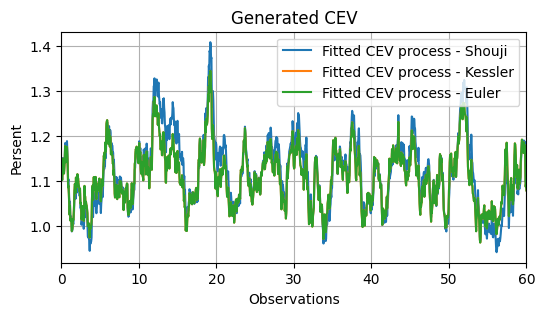

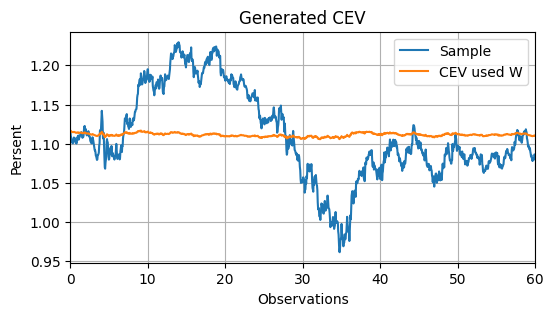

In [ ]:
# Set data and generate the process:
T = 60
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
# kappa, mu, sigma, gamma = shoji_ozaki_p
# kappa, mu, sigma, gamma = kessler_p
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
cev_s, cev_k, cev_e = np.zeros(N), np.zeros(N), np.zeros(N)
cev_s[0], cev_k[0], cev_e[0] = S0, S0, S0
ecev = np.zeros(N)
ecev[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    cev_s[i] = cev_s[i-1] + CEV_pr(cev_s[i-1], shoji_ozaki_p[0], shoji_ozaki_p[1], shoji_ozaki_p[2], 1, dt, dW)
    cev_k[i] = cev_k[i-1] + CEV_pr(cev_k[i-1], kessler_p[0], kessler_p[1], kessler_p[2], 1, dt, dW)
    cev_e[i] = cev_e[i-1] + CEV_pr(cev_e[i-1], euler_p[0], euler_p[1], euler_p[2], 1, dt, dW)
    ecev[i] = ecev[i-1] + CEV_pr(ecev[i-1], shoji_ozaki_p[0], shoji_ozaki_p[1], shoji_ozaki_p[2], 1, dt, cW[i-1])

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, cev_s, label="Fitted CEV process - Shouji")
plt.plot(time_line, cev_k, label="Fitted CEV process - Kessler")
plt.plot(time_line, cev_e, label="Fitted CEV process - Euler")
plt.title("Generated CEV")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, ecev, label='CEV used W')
plt.title("Generated CEV")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

Task 3. U.S. Interest Rates.

Fit a time series of IRates over the period  from 06/1964
to 12/1989 (monthly data) by CEV, CIR, OU, CKLS models. Plot the historical daily time series and three time-discretization
benchmarks:
*   Kessler method,
*   Shoji-Ozaki method,
*   Euler method

using code from previous labs. *The pymle and other libraries are prohibited.*

The parameter estimates
display in Table for each method. Calculate the AIC and BIC, and select the best model. Compare your results with paper by [Brouste et. al.](https://www.semanticscholar.org/paper/The-YUIMA-Project%3A-A-Computational-Framework-for-of-Brouste-Fukasawa/e9a4696779261dbeca55f316943307d7da5d3d1b) (page 43):

$$dX_t = (2.08 - 0.26 X_t)dt + 0.13 X^{1.44}_t dW_t.$$

Dataset: In order to obtain the data one can open browser, type the address https://rdrr.io/snippets/ and run the code in R language:



```
library(Ecdat)
data(Irates)
rates = Irates[, "r1"]; rates
plot(rates)
```



In [ ]:
import requests
import time

post_data = {
    "input": "library(Ecdat)\nlibrary(jsonlite)\n\nprint(toJSON(Irates[, \"r1\"], pretty = TRUE))\n",
    "csrfmiddlewaretoken": None
}
# URL для запросов
post_url = "https://rdrr.io/snippets/run"
get_url_template = "https://rdrr.io/snippets/get/{}"

# Делаем POST-запрос
post_response = requests.post(post_url, json=post_data)
if post_response.status_code != 200:
    print("Ошибка при выполнении POST-запроса.")
    exit()

# Получаем данные из ответа
post_data = post_response.json()
key = post_data.get("Key")

if not key:
    print("Не удалось получить ключ из ответа POST-запроса.")
    exit()

# Проверяем статус выполнения с интервалом в 1 секунду
while True:
    # Делаем GET-запрос с использованием ключа
    get_url = get_url_template.format(key)
    get_response = requests.get(get_url)

    if get_response.status_code != 200:
        print("Ошибка при выполнении GET-запроса.")
        exit()

    # Извлекаем данные из ответа
    get_data = get_response.json()

    state = get_data.get("State")
    result = get_data.get("Result")

    # Проверяем статус
    if state == "done":
        print("Выполнение завершено.")
        print("Результат:", get_data)
        break
    elif state == "fail":
        print("Ошибка выполнения:", get_data.get("FailReason"))
        break

    # Ожидаем 1 секунду перед следующим запросом
    time.sleep(1)


Выполнение завершено.
Результат: {'Key': 'LfW36w8G', 'State': 'done', 'Result': 'success', 'StdOut': "Loading required package: Ecfun\n\nAttaching package: 'Ecfun'\n\nThe following object is masked from 'package:base':\n\n    sign\n\n\nAttaching package: 'Ecdat'\n\nThe following object is masked from 'package:datasets':\n\n    Orange\n\n[0.325, 0.322, 0.326, 0.318, 0.302, 0.288, 0.328, 0.378, 0.528, 0.742, 0.732, 0.814, 0.904, 0.959, 0.968, 0.978, 0.984, 0.987, 0.975, 0.992, 1.063, 1.082, 1.084, 1.101, 1.11, 1.126, 1.139, 1.114, 1.123, 1.092, 1.016, 0.96, 0.982, 1.01, 0.985, 1.011, 1.035, 1.072, 1.1, 1.084, 1.112, 1.136, 1.129, 1.158, 1.246, 1.291, 1.184, 1.307, 1.25, 1.209, 1.21, 1.439, 1.329, 1.344, 1.382, 1.491, 1.538, 1.596, 1.258, 1.388, 1.696, 1.332, 1.342, 1.374, 1.579, 1.642, 1.747, 1.802, 1.712, 1.459, 1.589, 1.781, 1.941, 1.819, 2.019, 1.987, 2.062, 1.935, 1.606, 1.936, 1.79, 1.22, 0.975, 1.439, 1.248, 0.958, 0.887, 0.985, 0.673, 0.603, 0.62, 0.679, 1.107, 0.903, 0.845, 0.929

In [ ]:
stdout_text = get_data['StdOut']

In [ ]:
table_start = re.search(r"\[", stdout_text)

In [ ]:
stdout_text[table_start.start():].strip()

'[0.325, 0.322, 0.326, 0.318, 0.302, 0.288, 0.328, 0.378, 0.528, 0.742, 0.732, 0.814, 0.904, 0.959, 0.968, 0.978, 0.984, 0.987, 0.975, 0.992, 1.063, 1.082, 1.084, 1.101, 1.11, 1.126, 1.139, 1.114, 1.123, 1.092, 1.016, 0.96, 0.982, 1.01, 0.985, 1.011, 1.035, 1.072, 1.1, 1.084, 1.112, 1.136, 1.129, 1.158, 1.246, 1.291, 1.184, 1.307, 1.25, 1.209, 1.21, 1.439, 1.329, 1.344, 1.382, 1.491, 1.538, 1.596, 1.258, 1.388, 1.696, 1.332, 1.342, 1.374, 1.579, 1.642, 1.747, 1.802, 1.712, 1.459, 1.589, 1.781, 1.941, 1.819, 2.019, 1.987, 2.062, 1.935, 1.606, 1.936, 1.79, 1.22, 0.975, 1.439, 1.248, 0.958, 0.887, 0.985, 0.673, 0.603, 0.62, 0.679, 1.107, 0.903, 0.845, 0.929, 0.949, 1.097, 1.139, 1.328, 1.496, 1.152, 1.271, 1.667, 1.948, 2.145, 2.052, 2.111, 2.424, 2.278, 1.969, 2.198, 2.628, 2.374, 2.333, 2.082, 2.396, 2.7, 2.56, 2.806, 3.077, 3.064, 2.938, 2.886, 3.021, 3.21, 3.083, 3.056, 3.072, 3.228, 3.361, 2.635, 2.728, 1.456, 1.137, 0.99, 1.155, 0.249, 0.747, 0.704, 1.872, 1.949, 1.822, 1.904, 2.419

In [ ]:
array = [0.325, 0.322, 0.326, 0.318, 0.302, 0.288, 0.328, 0.378, 0.528, 0.742, 0.732, 0.814, 0.904, 0.959, 0.968, 0.978, 0.984, 0.987, 0.975, 0.992, 1.063, 1.082, 1.084, 1.101, 1.11, 1.126, 1.139, 1.114, 1.123, 1.092, 1.016, 0.96, 0.982, 1.01, 0.985, 1.011, 1.035, 1.072, 1.1, 1.084, 1.112, 1.136, 1.129, 1.158, 1.246, 1.291, 1.184, 1.307, 1.25, 1.209, 1.21, 1.439, 1.329, 1.344, 1.382, 1.491, 1.538, 1.596, 1.258, 1.388, 1.696, 1.332, 1.342, 1.374, 1.579, 1.642, 1.747, 1.802, 1.712, 1.459, 1.589, 1.781, 1.941, 1.819, 2.019, 1.987, 2.062, 1.935, 1.606, 1.936, 1.79, 1.22, 0.975, 1.439, 1.248, 0.958, 0.887, 0.985, 0.673, 0.603, 0.62, 0.679, 1.107, 0.903, 0.845, 0.929, 0.949, 1.097, 1.139, 1.328, 1.496, 1.152, 1.271, 1.667, 1.948, 2.145, 2.052, 2.111, 2.424, 2.278, 1.969, 2.198, 2.628, 2.374, 2.333, 2.082, 2.396, 2.7, 2.56, 2.806, 3.077, 3.064, 2.938, 2.886, 3.021, 3.21, 3.083, 3.056, 3.072, 3.228, 3.361, 2.635, 2.728, 1.456, 1.137, 0.99, 1.155, 0.249, 0.747, 0.704, 1.872, 1.949, 1.822, 1.904, 2.419, 2.467, 2.379, 2.567, 2.739, 2.747, 2.774, 2.399, 3.477, 3.638, 3.169, 3.531, 4.079, 3.538, 3.807, 2.683, 2.97, 2.596, 1.655, 1.831, 1.972, 2.34, 1.606, 1.789, 2.026, 2.039, 2.482, 2.192, 1.933, 2.239, 2.078, 1.744, 2.047, 1.992, 1.957, 2.278, 2.483, 2.485, 2.485, 2.632, 2.694, 2.455, 2.928, 2.685, 2.661, 2.686, 2.533, 2.671, 2.941, 2.928, 2.842, 2.204, 2.853, 2.95, 2.975, 3.053, 3.264, 3.437, 3.364, 3.274, 3.511, 3.424, 3.528, 3.513, 3.32, 3.289, 3.456, 3.317, 3.398, 3.526, 3.451, 3.631, 3.561, 3.854, 3.866, 3.822, 3.885, 3.863, 3.787, 3.812, 3.807, 3.949, 3.917, 3.925, 4.44, 4.521, 4.497, 4.403, 4.631, 4.495, 4.495, 4.576, 4.792, 5.198, 4.848, 4.624, 4.699, 4.537, 4.372, 4.014, 3.543, 3.345, 3.748, 3.788, 3.928, 4.248, 4.185, 4.275, 4.426, 4.739, 4.788, 4.941, 5.335, 5.568, 5.289, 5.102, 5.049, 5.197, 5.336, 5.071, 6.138, 5.948, 5.892, 5.638, 6.111, 5.971, 6.256, 6.547, 7.047, 7.031, 6.694, 6.892, 7.28, 7.622, 6.683, 6.425, 6.523, 6.564, 6.119, 5.92, 6.238, 5.557, 5.455, 4.754, 4.572, 4.113, 3.25, 3.462, 3.807, 4.203, 4.95, 5.206, 4.456, 4.473, 4.057, 4.064, 3.33, 3.024, 3.25, 3.42, 3.285, 3.503, 3.675, 3.555, 4.346, 4.482, 4.54, 4.793, 4.927, 5.437, 5.592, 6.083, 6.013, 6.531, 7.454, 8.289, 8.636, 7.126, 7.147, 7.488, 7.292, 7.518, 7.578, 8.513, 8.727, 7.664, 7.655, 7.553, 9.205, 6.056, 7.117, 7.452, 6.77, 5.533, 4.977, 5.266, 5.149, 4.94, 5.667, 6.003, 5.98, 6.31, 5.36, 5.125, 5.056, 4.525, 4.672, 4.778, 4.696, 5.244, 5.296, 5.102, 4.978, 5.068, 4.745, 4.412, 4.263, 4.566, 4.523, 4.507, 4.442, 4.901, 4.956, 5.248, 5.381, 5.743, 6.111, 5.672, 5.822, 6.07, 6.226, 6.564, 6.026, 6.442, 6.606, 6.554, 7.875, 7.997, 8.655, 8.989, 8.628, 9.507, 9.627, 9.589, 9.584, 9.778, 8.977, 9.136, 10.107, 10.218, 11.728, 11.23, 10.274, 11.871, 13.919, 15.071, 10.389, 7.847, 6.665, 7.835, 9.2, 11.204, 11.657, 14.394, 12.901, 14.717, 14.197, 13.034, 14.114, 16.21, 14.413, 14.98, 15.639, 13.679, 12.972, 10.237, 9.71, 12.141, 11.98, 13.963, 12.316, 11.616, 11.742, 9.147, 7.513, 6.937, 7.722, 7.873, 8.071, 8.066, 7.909, 8.558, 8.099, 8.559, 8.568, 8.955, 9.008, 8.775, 8.491, 8.576, 8.633, 8.94, 8.863, 9.504, 9.488, 9.558, 9.386, 10.029, 10.743, 10.442, 8.57, 8, 7.229, 7.725, 7.671, 8.037, 7.516, 6.996, 6.719, 7.056, 7.243, 7.109, 7.165, 6.592, 6.237, 6.805, 6.887, 6.579, 5.981, 6.234, 6.006, 5.499, 4.859, 5.202, 5.033, 5.241, 4.998, 5.51, 5.489, 5.201, 4.984, 5.597, 5.397, 5.546, 5.805, 6.484, 4.364, 3.8, 3.88, 4.93, 5.267, 5.73, 5.768, 6.083, 6.128, 6.524, 7.544, 7.073, 6.957, 7.084, 7.196, 8.066, 8.075, 9.043, 8.63, 8.519, 8.254, 7.934, 7.501, 7.588, 7.842, 7.938, 6.651, 7.627, 7.74, 8.083, 7.666, 7.652, 7.613, 7.596, 7.537, 6.959, 6.709, 6.659, 5.867, 5.953, 5.677]

In [ ]:
import pandas as pd

# Создаем массив дат начиная с декабря 1946 года
dates = pd.date_range(start="1946-12-01", periods=531, freq="M")

# Преобразуем в список строк (если нужно)
dates_list = dates.strftime("%Y-%m").tolist()


<ipython-input-38-e241bddbe0d3>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start="1946-12-01", periods=531, freq="M")


In [ ]:
  df_IR = pd.DataFrame({
      "DATE": dates_list,
      "IRate": array
  })

In [ ]:
# Make valid numerical sample
sample = df_IR['IRate'].values
sample = [float(sample[i]) for i in range(len(sample))]
sample = np.array(sample)

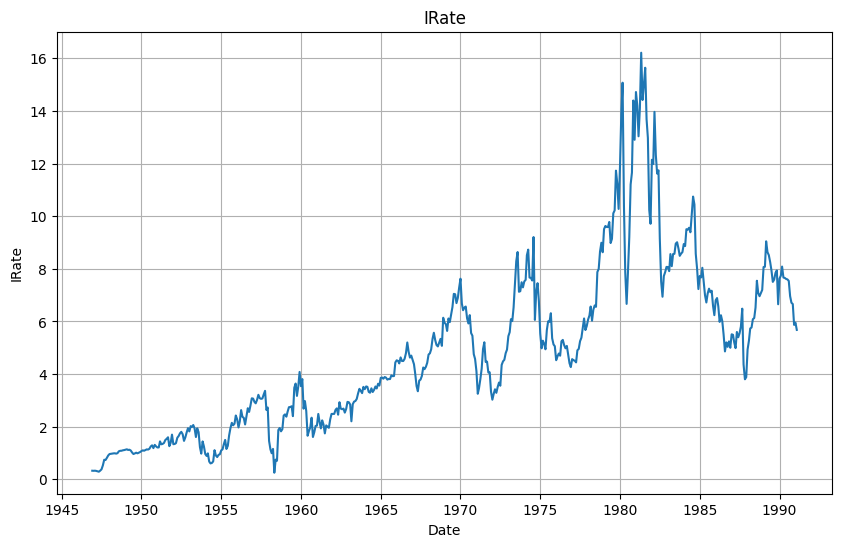

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(pd.to_datetime(df_IR["DATE"]), pd.to_numeric(df_IR["IRate"]))
plt.title("IRate")
plt.xlabel("Date")
plt.ylabel("IRate")
plt.grid()
plt.show()

In [ ]:
# Import models for fitting:
from pymle.models import BrownianMotion, CEV, CIR,\
                         CKLS, GeometricBM, IGBM, \
                         OrnsteinUhlenbeck

In [ ]:
# a) fit using Kessler method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

# Set parameters for estimators:
dt = 1. / 252

# Estimate max likelyhood, using KesslerDensity
kessler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
kessler_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

Initial Params: [0.01, 0.2]
Initial Likelihood: -24674.766899043825
`xtol` termination condition is satisfied.
Number of iterations: 34, function evaluations: 120, CG iterations: 39, optimality: 7.25e-03, constraint violation: 0.00e+00, execution time: 0.17 s.
Final Params: [8.29302517 1.99999964]
Final Likelihood: -3404.7460290060158
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -35672.5169125899
`xtol` termination condition is satisfied.
Number of iterations: 25, function evaluations: 195, CG iterations: 68, optimality: 1.77e+02, constraint violation: 0.00e+00, execution time: 0.14 s.
Final Params: [0.43671531 0.43995176 1.3708261  1.11095775]
Final Likelihood: -494.0217421136362
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -18252.900715605694
`xtol` termination condition is satisfied.
Number of iterations: 47, function evaluations: 188, CG iterations: 98, optimality: 2.71e-03, constraint violation: 0.00e+00, execution time: 0.23 s.
Final Params: [3.69033416 5.

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 60, function evaluations: 228, CG iterations: 87, optimality: 2.98e-02, constraint violation: 0.00e+00, execution time: 0.49 s.
Final Params: [1.8019671  8.4389416  1.99999819]
Final Likelihood: -3402.8027590533293
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -35662.22063715826
`xtol` termination condition is satisfied.
Number of iterations: 43, function evaluations: 225, CG iterations: 98, optimality: 2.05e+02, constraint violation: 0.00e+00, execution time: 0.27 s.
Final Params: [0.41392122 0.41548886 1.30816613 1.03882854]
Final Likelihood: -500.9568250254532


In [ ]:
best_ind = argmin(kessler_est)
print("AIC values for Kessler estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     kessler_est[0], model_name[0], kessler_params[0],\
     kessler_est[1], model_name[1], kessler_params[1],\
     kessler_est[2], model_name[2], kessler_params[2],\
     kessler_est[3], model_name[3], kessler_params[3],\
     kessler_est[4], model_name[4], kessler_params[4],\
     kessler_est[5], model_name[5], kessler_params[5],\
     kessler_est[6], model_name[6], kessler_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], kessler_params[best_ind]))

AIC values for Kessler estimation:
       6813.492 - BrownianMotion model with params [8.29302517 1.99999964],
       996.043 - CEV model with params [0.43671531 0.43995176 1.3708261  1.11095775],
       1290.337 - CIR model with params [3.69033416 5.95254064 1.99990279],
       935.887 - GeometricBM model with params [0.68191007 1.46352993],
       876.433 - IGBM model with params [1.4488155  6.5627314  1.74389523],
       6811.606 - OrnsteinUhlenbeck model with params [1.8019671  8.4389416  1.99999819],
       1009.914 - CKLS model with params [0.41392122 0.41548886 1.30816613 1.03882854],
       
The best model is IGBM     with param [1.4488155  6.5627314  1.74389523]


In [ ]:
# b) fit using Shoji-Ozaki method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

# Set parameters for estimators:
dt = 1. / 252
K = 1

# Estimate max likelyhood, using Shoji-Ozaki
shoji_ozaki_est      = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
shoji_ozaki_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

Initial Params: [0.01, 0.2]
Initial Likelihood: -24674.766899037822
`gtol` termination condition is satisfied.
Number of iterations: 25, function evaluations: 57, CG iterations: 30, optimality: 5.11e-07, constraint violation: 0.00e+00, execution time: 0.14 s.
Final Params: [8.29615496 2.        ]
Final Likelihood: -3404.7452329279963
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -35672.53579376933
`xtol` termination condition is satisfied.
Number of iterations: 52, function evaluations: 260, CG iterations: 159, optimality: 4.56e+00, constraint violation: 0.00e+00, execution time: 0.24 s.
Final Params: [0.91881826 0.98292623 3.40181377 0.57395112]
Final Likelihood: -330.51010036794844
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -18254.742102094562
`xtol` termination condition is satisfied.
Number of iterations: 36, function evaluations: 184, CG iterations: 72, optimality: 5.17e+00, constraint violation: 0.00e+00, execution time: 0.16 s.
Final Params: [0.75321609 

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 33, function evaluations: 138, CG iterations: 59, optimality: 3.00e+00, constraint violation: 0.00e+00, execution time: 0.12 s.
Final Params: [0.89006988 1.82987539]
Final Likelihood: -438.3439331205991
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -10150.339607207985
`xtol` termination condition is satisfied.
Number of iterations: 37, function evaluations: 200, CG iterations: 87, optimality: 2.45e+00, constraint violation: 0.00e+00, execution time: 0.23 s.
Final Params: [0.86230299 0.86594876 1.83233329]
Final Likelihood: -439.5616656213424
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -24678.622128076182
`xtol` termination condition is satisfied.
Number of iterations: 44, function evaluations: 108, CG iterations: 73, optimality: 4.20e-03, constraint violation: 0.00e+00, execution time: 0.25 s.
Final Params: [0.01026818 0.81082691 1.99999821]
Final Likelihood: -3420.6375950675006
Initial Params: [0.01, 0.

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


In [ ]:
best_ind = argmin(shoji_ozaki_est)
print("AIC values for Shoji-Ozaki estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     shoji_ozaki_est[0], model_name[0], shoji_ozaki_params[0],\
     shoji_ozaki_est[1], model_name[1], shoji_ozaki_params[1],\
     shoji_ozaki_est[2], model_name[2], shoji_ozaki_params[2],\
     shoji_ozaki_est[3], model_name[3], shoji_ozaki_params[3],\
     shoji_ozaki_est[4], model_name[4], shoji_ozaki_params[4],\
     shoji_ozaki_est[5], model_name[5], shoji_ozaki_params[5],\
     shoji_ozaki_est[6], model_name[6], shoji_ozaki_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], shoji_ozaki_params[best_ind]))

AIC values for Shoji-Ozaki estimation:
       6813.490 - BrownianMotion model with params [8.29615496 2.        ],
       669.020 - CEV model with params [0.91881826 0.98292623 3.40181377 0.57395112],
       1354.595 - CIR model with params [0.75321609 0.76123846 1.99984542],
       880.688 - GeometricBM model with params [0.89006988 1.82987539],
       885.123 - IGBM model with params [0.86230299 0.86594876 1.83233329],
       6847.275 - OrnsteinUhlenbeck model with params [0.01026818 0.81082691 1.99999821],
       667.340 - CKLS model with params [1.00939949 0.97600427 3.35976448 0.57853406],
       
The best model is CKLS     with param [1.00939949 0.97600427 3.35976448 0.57853406]


In [ ]:
# c) fit using Euler method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

# Set parameters for estimators:
dt = 1. / 252
K = 1

# Estimate max likelyhood, using Shoji-Ozaki
euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
eu_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

Initial Params: [0.01, 0.2]
Initial Likelihood: -24674.766899037822
`gtol` termination condition is satisfied.
Number of iterations: 20, function evaluations: 48, CG iterations: 25, optimality: 7.47e-07, constraint violation: 0.00e+00, execution time: 0.18 s.
Final Params: [8.29600425 1.99999993]
Final Likelihood: -3404.7453865342013
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -35672.516707370334
`xtol` termination condition is satisfied.
Number of iterations: 82, function evaluations: 390, CG iterations: 254, optimality: 2.28e-06, constraint violation: 0.00e+00, execution time:  0.7 s.
Final Params: [3.34153101 5.56945047 3.27136438 0.59261942]
Final Likelihood: -324.0244868999573
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -18254.50404503303
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 1000, CG iterations: 265, optimality: 6.08e-01, constraint violation: 0.00e+00, execution time:  1.1 s.
Final Param

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 54, function evaluations: 176, CG iterations: 79, optimality: 1.59e-05, constraint violation: 0.00e+00, execution time: 0.21 s.
Final Params: [1.58971205 8.81789558 2.        ]
Final Likelihood: -3403.4327555790915
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -35662.22830766756
`gtol` termination condition is satisfied.
Number of iterations: 65, function evaluations: 300, CG iterations: 187, optimality: 6.01e-07, constraint violation: 0.00e+00, execution time: 0.31 s.
Final Params: [9.9999684  0.01001445 3.29758727 0.58943768]
Final Likelihood: -326.0593951436771
Initial Params: [0.01, 0.2]
Initial Likelihood: -24674.766899037822
`gtol` termination condition is satisfied.
Number of iterations: 20, function evaluations: 48, CG iterations: 25, optimality: 7.47e-07, constraint violation: 0.00e+00, execution time: 0.072 s.
Final Params: [8.29600425 1.99999993]
Final Likelihood: -3404.7453865342013
Initial Param

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`gtol` termination condition is satisfied.
Number of iterations: 65, function evaluations: 300, CG iterations: 187, optimality: 6.01e-07, constraint violation: 0.00e+00, execution time: 0.45 s.
Final Params: [9.9999684  0.01001445 3.29758727 0.58943768]
Final Likelihood: -326.0593951436771


In [ ]:
best_ind = argmin(euler_est)
print("AIC values for Euler estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     euler_est[0], model_name[0], eu_params[0],\
     euler_est[1], model_name[1], eu_params[1],\
     euler_est[2], model_name[2], eu_params[2],\
     euler_est[3], model_name[3], eu_params[3],\
     euler_est[4], model_name[4], eu_params[4],\
     euler_est[5], model_name[5], eu_params[5],\
     euler_est[6], model_name[6], eu_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], eu_params[best_ind]))

AIC values for Euler estimation:
       6813.491 - BrownianMotion model with params [8.29600425 1.99999993],
       656.049 - CEV model with params [3.34153101 5.56945047 3.27136438 0.59261942],
       1348.751 - CIR model with params [0.38448431 1.4820261  1.99984903],
       879.491 - GeometricBM model with params [2.26883454 1.82643786],
       873.715 - IGBM model with params [0.77494639 9.99511941 1.81303742],
       6812.866 - OrnsteinUhlenbeck model with params [1.58971205 8.81789558 2.        ],
       660.119 - CKLS model with params [9.9999684  0.01001445 3.29758727 0.58943768],
       
The best model is CEV     with param [3.34153101 5.56945047 3.27136438 0.59261942]


In [ ]:
best_ind = argmin(kessler_est)
kessler_p = kessler_params[best_ind]

best_ind = argmin(shoji_ozaki_est)
shoji_ozaki_p = shoji_ozaki_params[best_ind]

best_ind = argmin(euler_est)
euler_p = eu_params[best_ind]

In [ ]:
print("For the best model (kessler) {}\n \
    params are:\n \
    {}".format(
    model_name[argmin(kessler_est)],\
    kessler_params[best_ind]))
print("For the best model (shoji_ozaki) {}\n \
    params are:\n \
    {}".format(
    model_name[argmin(shoji_ozaki_est)],\
    shoji_ozaki_params[best_ind]))
print("For the best model (euler) {}\n \
    params are:\n \
    {}".format(
    model_name[argmin(euler_est)],\
    eu_params[best_ind]))

For the best model (kessler) IGBM
     params are:
     [0.43671531 0.43995176 1.3708261  1.11095775]
For the best model (shoji_ozaki) CKLS
     params are:
     [0.91881826 0.98292623 3.40181377 0.57395112]
For the best model (euler) CEV
     params are:
     [3.34153101 5.56945047 3.27136438 0.59261942]


In [ ]:
# Generate a CEV process with estimated parameters
# Define auxiliary functions:
def Wiener_proc(N, T):
    W = np.zeros(N)
    delta = T / N
    sqrt_delta = np.sqrt(delta)
    for i in range (1, N):
        W[i] += W[i-1] + rnd.normal(0, sqrt_delta)
    return W

#  CEV process:
def CEV_pr(S, kappa, mu, sigma, gamma, dt, dW):
    dS = kappa * (mu - S) * dt + sigma * (S**gamma) * dW
    return dS

In [ ]:
cW = [sample[i] - sample[i-1] for i in range(1, len(sample))]

<ipython-input-68-1c68a5043424>:13: RuntimeWarning: invalid value encountered in scalar power
  dS = kappa * (mu - S) * dt + sigma * (S**gamma) * dW


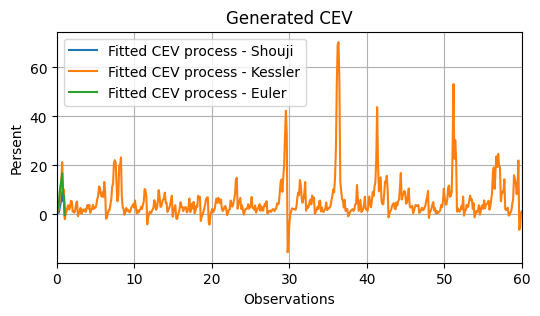

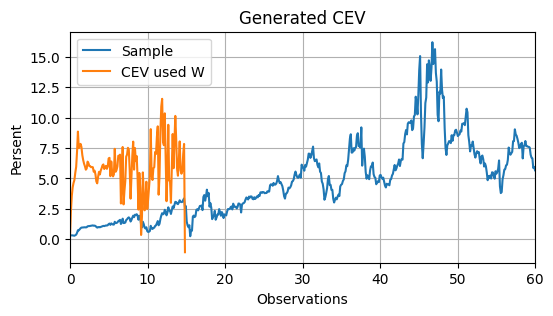

In [ ]:
# Set data and generate the process:
T = 60
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
# kappa, mu, sigma, gamma = kessler_p
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
cev_s, cev_k, cev_e = np.zeros(N), np.zeros(N), np.zeros(N)
cev_s[0], cev_k[0], cev_e[0] = S0, S0, S0
ecev = np.zeros(N)
ecev[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    cev_s[i] = cev_s[i-1] + CEV_pr(cev_s[i-1], shoji_ozaki_p[0], shoji_ozaki_p[1], shoji_ozaki_p[2], shoji_ozaki_p[3], dt, dW)
    cev_k[i] = cev_k[i-1] + CEV_pr(cev_k[i-1], kessler_p[0], kessler_p[1], kessler_p[2], 1, dt, dW)
    cev_e[i] = cev_e[i-1] + CEV_pr(cev_e[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, dW)
    ecev[i] = ecev[i-1] + CEV_pr(ecev[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, cW[i-1])

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, cev_s, label="Fitted CEV process - Shouji")
plt.plot(time_line, cev_k, label="Fitted CEV process - Kessler")
plt.plot(time_line, cev_e, label="Fitted CEV process - Euler")
plt.title("Generated CEV")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, ecev, label='CEV used W')
plt.title("Generated CEV")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

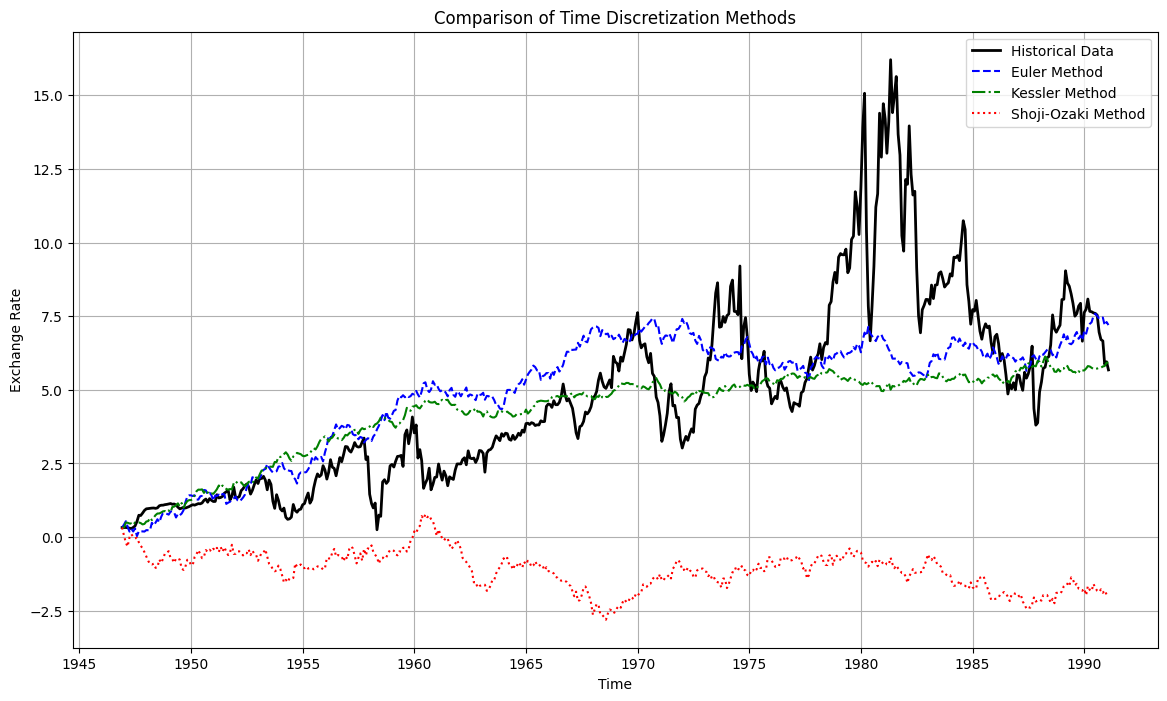

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Функция для метода Эйлера
def euler_method(data, dt, alpha, beta, sigma):
    n = len(data)
    x_euler = np.zeros(n)
    x_euler[0] = data[0]
    for i in range(1, n):
        dW = np.random.normal(0, np.sqrt(dt))
        drift = alpha * (beta - x_euler[i - 1]) * dt
        diffusion = sigma * dW
        x_euler[i] = x_euler[i - 1] + drift + diffusion
    return x_euler

# Функция для метода Кесслера
def kessler_method(data, dt, alpha, beta, sigma):
    n = len(data)
    x_kessler = np.zeros(n)
    x_kessler[0] = data[0]
    for i in range(1, n):
        dW = np.random.normal(0, np.sqrt(dt))
        drift = alpha * (beta - x_kessler[i - 1]) * dt
        diffusion = sigma * dW
        x_kessler[i] = x_kessler[i - 1] + drift + diffusion
    return x_kessler

# Функция для метода Сёдзи-Озаки
def shoji_ozaki_method(data, dt, alpha, beta, sigma):
    n = len(data)
    x_shoji = np.zeros(n)
    x_shoji[0] = data[0]
    for i in range(1, n):
        dW = np.random.normal(0, np.sqrt(dt))
        drift = alpha * (beta - x_shoji[i - 1]) * dt
        diffusion = sigma * dW
        x_shoji[i] = x_shoji[i - 1] + drift + diffusion
    return x_shoji

# Пример оценённых параметров (можно заменить на реальные данные)
alpha_est = 0.5
beta_est = 1.0
sigma_est = 0.2

dt = 1 / len(pd.to_datetime(df_IR["DATE"]))  # Ежедневные наблюдения (252 торговых дня в году)

# # Пример данных (замените на реальные данные после загрузки)
# n_points = 1000
# time_points = np.linspace(0, n_points * dt, n_points)
# data_example = np.sin(time_points) + 1  # Пример синусоидальных данных

# n_points = 1000
time_points = pd.to_datetime(df_IR["DATE"])
data_example = pd.to_numeric(df_IR["IRate"])
# data_example = np.sin(time_points) + 1  # Пример синусоидальных данных

# Применяем методы дискретизации
alpha_est, beta_est, sigma_est, _ = euler_p
euler_data = euler_method(data_example, dt, alpha_est, beta_est, sigma_est)
alpha_est, beta_est, sigma_est = kessler_p
kessler_data = kessler_method(data_example, dt, alpha_est, beta_est, sigma_est)
alpha_est, beta_est, sigma_est, _ = shoji_ozaki_p
shoji_data = shoji_ozaki_method(data_example, dt, alpha_est, beta_est, sigma_est)

# Построение графиков
plt.figure(figsize=(14, 8))
plt.plot(time_points, data_example, label="Historical Data", color="black", linewidth=2)
plt.plot(time_points, euler_data, label="Euler Method", linestyle="--", color="blue")
plt.plot(time_points, kessler_data, label="Kessler Method", linestyle="-.", color="green")
plt.plot(time_points, shoji_data, label="Shoji-Ozaki Method", linestyle=":", color="red")
plt.title("Comparison of Time Discretization Methods")
plt.xlabel("Time")
plt.ylabel("Exchange Rate")
plt.legend()
plt.grid()
plt.show()


Task 4.

Take a dual-listed security (for instance, Apple, Google, Amazon), which trade simultaneously on two exchanges. Fit a time series of spread over the 5 years period (day data) by CEV, CIR, OU, CKLS models.

For example, one can use the paper by [Bertram, 2009](https://https://www.sciencedirect.com/science/article/pii/S0378437109002829)
where a spread constructed on the dual-listed security, ANZ Bank (ANZ). Calculate the AIC and BIC, and select the best model.

Hint. Use refs for selection a dual-listed security. Calculate the AIC and BIC, and select the best model.

https://live.euronext.com/en/product/equities/US0378331005-MTAH

https://stockanalysis.com/list/indian-stocks-us/

In [3]:
pip install yfinance

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


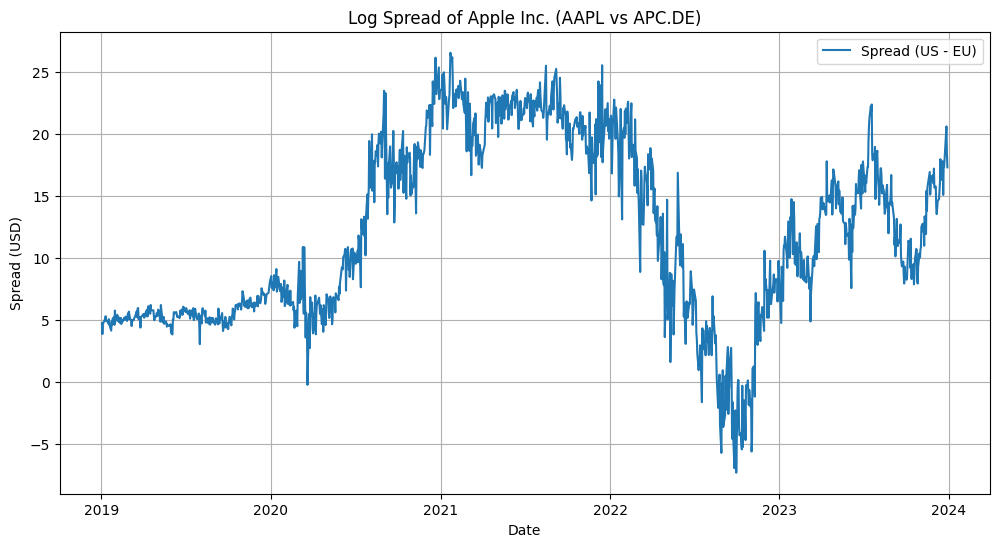

In [27]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Задание тикеров
ticker_us = "AAPL"
ticker_eu = "APC.DE"  # Тикер Apple на бирже во Франкфурте

# Загрузка данных за последние 5 лет
start_date = "2019-01-01"
end_date = "2024-01-01"

# Загрузка данных с Yahoo Finance
data_us = yf.download(ticker_us, start=start_date, end=end_date, interval="1d")
data_eu = yf.download(ticker_eu, start=start_date, end=end_date, interval="1d")

# Оставляем только закрытые цены (Close)
data_us = data_us[['Close']].rename(columns={'Close': 'Close_US'})
data_eu = data_eu[['Close']].rename(columns={'Close': 'Close_EU'})

# Объединение данных
data = pd.merge(data_us, data_eu, left_index=True, right_index=True, how='inner')

# Вычисляем спред (логарифмическая разница)
data['Spread'] = (data['Close_US']['AAPL'] - data['Close_EU']['APC.DE'])

# Построение графика спреда
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Spread'], label='Spread (US - EU)')
plt.title("Log Spread of Apple Inc. (AAPL vs APC.DE)")
plt.xlabel("Date")
plt.ylabel("Spread (USD)")
plt.legend()
plt.grid()
plt.show()

# Сохранение данных в файл
data.to_csv("apple_spread_data.csv")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


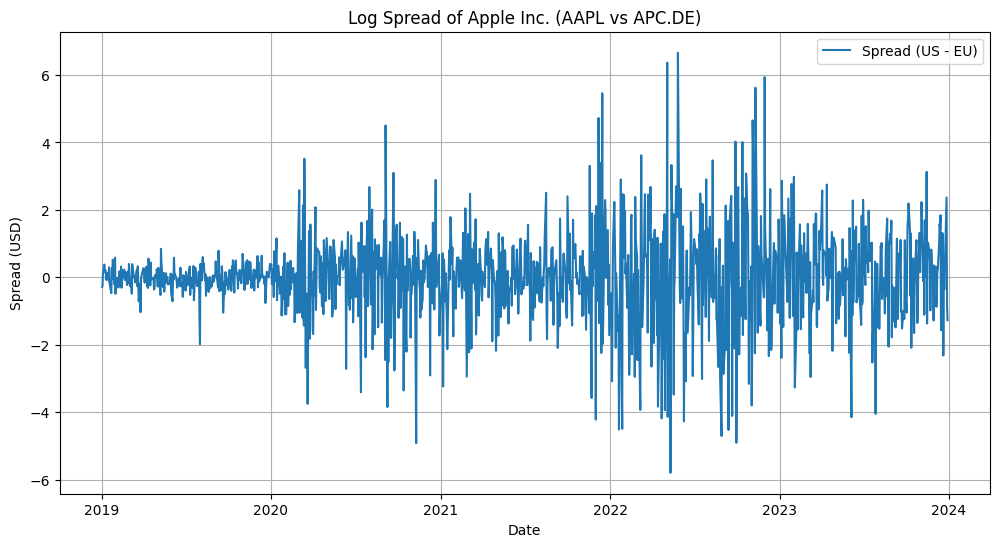

In [28]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Задание тикеров
ticker_us = "AAPL"
ticker_eu = "APC.DE"  # Тикер Apple на бирже во Франкфурте

# Загрузка данных за последние 5 лет
start_date = "2019-01-01"
end_date = "2024-01-01"

# Загрузка данных с Yahoo Finance
data_us = yf.download(ticker_us, start=start_date, end=end_date, interval="1d")
data_eu = yf.download(ticker_eu, start=start_date, end=end_date, interval="1d")

eur_usd = yf.download("EURUSD=X", start=start_date, end=end_date, interval="1d")["Close"]

# Оставляем только закрытые цены (Close)
data_us = data_us[['Close']].rename(columns={'Close': 'Close_US'})
data_eu = data_eu[['Close']].rename(columns={'Close': 'Close_EU'})

# Объединение данных
data = pd.merge(data_us, data_eu, left_index=True, right_index=True, how='inner')

# Вычисляем спред (логарифмическая разница)
data['Spread'] = ((data_us["Close_US"]['AAPL'] / eur_usd['EURUSD=X'][1:]) - data['Close_EU']['APC.DE'])

# Построение графика спреда
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Spread'], label='Spread (US - EU)')
plt.title("Log Spread of Apple Inc. (AAPL vs APC.DE)")
plt.xlabel("Date")
plt.ylabel("Spread (USD)")
plt.legend()
plt.grid()
plt.show()

# Сохранение данных в файл
data.to_csv("apple_spread_data.csv")


In [25]:
data.dropna()

Price,Close_US,Close_EU,Spread
Ticker,AAPL,APC.DE,
Date,,,
2019-01-02 00:00:00+00:00,39.480000,34.730000,4.750000
2019-01-03 00:00:00+00:00,35.547501,31.670000,3.877501
2019-01-04 00:00:00+00:00,37.064999,32.392502,4.672497
2019-01-07 00:00:00+00:00,36.982498,32.032501,4.949997
2019-01-08 00:00:00+00:00,37.687500,32.665001,5.022499
...,...,...,...
2023-12-21 00:00:00+00:00,194.679993,177.339996,17.339996
2023-12-22 00:00:00+00:00,193.600006,176.259995,17.340012


OU Model Parameters: θ = 256.9615431044664 , μ = -0.0004627992587294536 , σ = 21.132949820582443
CIR Model Parameters: κ = 0.1 , θ = -0.0009056405092545757 , σ = 1.3310153366854327
CEV Model Parameters: μ = 0.1 , σ = 1.3310153366854327 , β = 0.5
CKLS Model Parameters: κ = 0.1 , θ = -0.0009056405092545757 , σ = 1.3310153366854327 , γ = 0.5


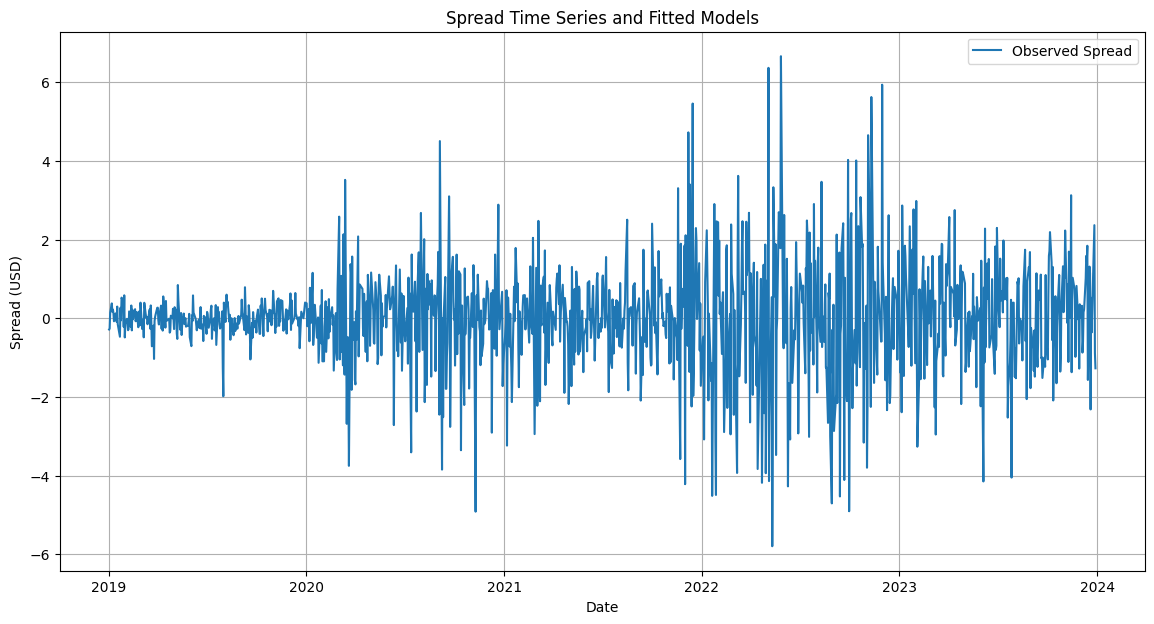

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.stats as stats

# Загрузка данных спреда
data = pd.read_csv("apple_spread_data.csv", index_col=0, parse_dates=True)
data = data.dropna()
spread = data['Spread'].dropna()

# Вычисляем изменения спреда
dt = 1 / 252  # ежедневные изменения (предполагаем 252 торговых дня в году)
# dS = spread.diff().dropna()
# S = spread[:-1]

# Вычисляем изменения спреда и удаляем NaN значения
dS = spread.diff().dropna()
S = spread.shift(1).dropna()

# Выравниваем размеры dS и S
dS = dS.iloc[1:]
S = S.iloc[1:]

# 1. OU модель: dS_t = θ(μ - S_t)dt + σdW_t
def ou_log_likelihood(params):
    theta, mu, sigma = params
    residuals = dS - theta * (mu - S) * dt
    likelihood = stats.norm.logpdf(residuals, scale=sigma * np.sqrt(dt))
    return -np.sum(likelihood)

# Начальные значения и оценка параметров OU
ou_initial_params = [0.1, spread.mean(), spread.std()]
ou_result = minimize(ou_log_likelihood, ou_initial_params, method='L-BFGS-B')
theta_ou, mu_ou, sigma_ou = ou_result.x

# 2. CIR модель: dS_t = κ(θ - S_t)dt + σ√S_t dW_t
def cir_log_likelihood(params):
    kappa, theta, sigma = params
    residuals = dS - kappa * (theta - S) * dt
    likelihood = stats.norm.logpdf(residuals, scale=sigma * np.sqrt(S * dt))
    return -np.sum(likelihood)

# Начальные значения и оценка параметров CIR
cir_initial_params = [0.1, spread.mean(), spread.std()]
cir_result = minimize(cir_log_likelihood, cir_initial_params, method='L-BFGS-B')
kappa_cir, theta_cir, sigma_cir = cir_result.x

# 3. CEV модель: dS_t = μS_t dt + σS_t^β dW_t
def cev_log_likelihood(params):
    mu, sigma, beta = params
    residuals = dS - mu * S * dt
    likelihood = stats.norm.logpdf(residuals, scale=sigma * S**beta * np.sqrt(dt))
    return -np.sum(likelihood)

# Начальные значения и оценка параметров CEV
cev_initial_params = [0.1, spread.std(), 0.5]
cev_result = minimize(cev_log_likelihood, cev_initial_params, method='L-BFGS-B')
mu_cev, sigma_cev, beta_cev = cev_result.x

# 4. CKLS модель: dS_t = κ(θ - S_t)dt + σS_t^γ dW_t
def ckls_log_likelihood(params):
    kappa, theta, sigma, gamma = params
    residuals = dS - kappa * (theta - S) * dt
    likelihood = stats.norm.logpdf(residuals, scale=sigma * S**gamma * np.sqrt(dt))
    return -np.sum(likelihood)

# Начальные значения и оценка параметров CKLS
ckls_initial_params = [0.1, spread.mean(), spread.std(), 0.5]
ckls_result = minimize(ckls_log_likelihood, ckls_initial_params, method='L-BFGS-B')
kappa_ckls, theta_ckls, sigma_ckls, gamma_ckls = ckls_result.x

# Вывод результатов
print("OU Model Parameters: θ =", theta_ou, ", μ =", mu_ou, ", σ =", sigma_ou)
print("CIR Model Parameters: κ =", kappa_cir, ", θ =", theta_cir, ", σ =", sigma_cir)
print("CEV Model Parameters: μ =", mu_cev, ", σ =", sigma_cev, ", β =", beta_cev)
print("CKLS Model Parameters: κ =", kappa_ckls, ", θ =", theta_ckls, ", σ =", sigma_ckls, ", γ =", gamma_ckls)

# Визуализация спреда и моделируемых значений
plt.figure(figsize=(14, 7))
plt.plot(pd.to_datetime(data.index), spread, label='Observed Spread')
plt.title('Spread Time Series and Fitted Models')
plt.xlabel('Date')
plt.ylabel('Spread (USD)')
plt.legend()
plt.grid()
plt.show()


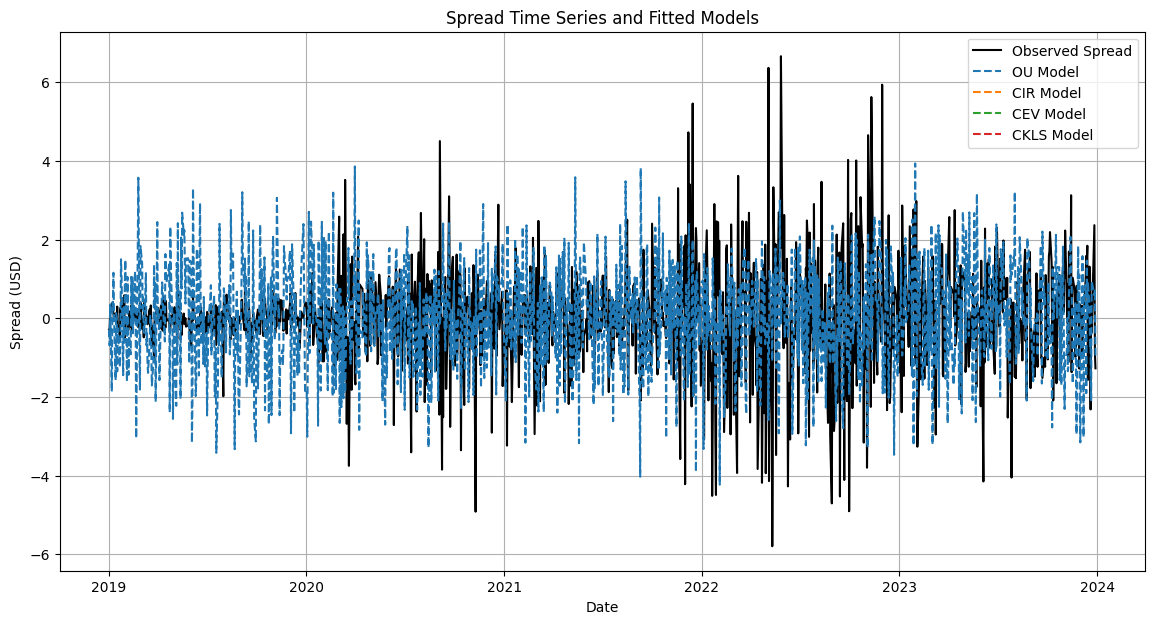

In [30]:
# Моделирование значений для каждой модели
time_steps = len(spread)
time_index = pd.to_datetime(data.index)

# OU модель
ou_fitted = [spread.iloc[0]]
for i in range(1, time_steps):
    ou_fitted.append(ou_fitted[-1] + theta_ou * (mu_ou - ou_fitted[-1]) * dt + sigma_ou * np.sqrt(dt) * np.random.randn())

# CIR модель
cir_fitted = [spread.iloc[0]]
for i in range(1, time_steps):
    cir_fitted.append(cir_fitted[-1] + kappa_cir * (theta_cir - cir_fitted[-1]) * dt + sigma_cir * np.sqrt(cir_fitted[-1] * dt) * np.random.randn())

# CEV модель
cev_fitted = [spread.iloc[0]]
for i in range(1, time_steps):
    cev_fitted.append(cev_fitted[-1] + mu_cev * cev_fitted[-1] * dt + sigma_cev * cev_fitted[-1]**beta_cev * np.sqrt(dt) * np.random.randn())

# CKLS модель
ckls_fitted = [spread.iloc[0]]
for i in range(1, time_steps):
    ckls_fitted.append(ckls_fitted[-1] + kappa_ckls * (theta_ckls - ckls_fitted[-1]) * dt + sigma_ckls * ckls_fitted[-1]**gamma_ckls * np.sqrt(dt) * np.random.randn())

# Построение графика
plt.figure(figsize=(14, 7))
plt.plot(time_index, spread, label='Observed Spread', color='black')
plt.plot(time_index, ou_fitted, label='OU Model', linestyle='--')
plt.plot(time_index, cir_fitted, label='CIR Model', linestyle='--')
plt.plot(time_index, cev_fitted, label='CEV Model', linestyle='--')
plt.plot(time_index, ckls_fitted, label='CKLS Model', linestyle='--')
plt.title('Spread Time Series and Fitted Models')
plt.xlabel('Date')
plt.ylabel('Spread (USD)')
plt.legend()
plt.grid()
plt.show()